# Psuedobulk creation with decoupler
**Authorship:** Adam Klie (last updated: 08/27/2023)<br>
***
**Description:** This notebook performs a

# Set-up

In [189]:
# Global Imports
import os
import sys
import yaml
import random
import time
import datetime
import logging
import scanpy as sc
import decoupler as dc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Sys
sys.path.append("/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/bin/data_analysis/decoupler")

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 3

In [190]:
# Inputs
input_h5ad_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2023_11_15/cellcommander/integrated/rna/annotate/annotate.h5ad"
metadata_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/metadata/26Nov23/sample_metadata_26Nov23.tsv"
outdir_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/analysis/2023_11_29/integrated/decoupler/pseudobulk/sample"

# Make a worfklow hash
import hashlib
workflow_hash = hashlib.sha1()
if not os.path.exists(outdir_path):
    os.makedirs(outdir_path)

In [191]:
# Method params
groupby_keys = ["sample", "integrated_manual_cellid_annotation", "condition"]
cellid_key = "integrated_manual_cellid_annotation"
compare_key = "condition"
target_max_cells_per_pb = None
obs_key = "pseudobulk"
mode = "sum"
min_cells = 10
min_counts = 1000

In [192]:
# Make and log params
data_params = {
    "input_h5ad_path": input_h5ad_path,
    "outdir_path": outdir_path,
}
method_params = {
    "groupby_keys": groupby_keys,
    "target_max_cells_per_pb": target_max_cells_per_pb,
    "obs_key": obs_key,
    "mode": mode,
    "min_cells": min_cells,
    "min_counts": min_counts,
}
version_params = {
    "workflow_hash": workflow_hash.hexdigest(),
    "Python": sys.version[:5],
    "Scanpy": sc.__version__,
    "decoupler": dc.__version__,
}
params = {"data": data_params, "run": method_params, "versions": version_params}
if not os.path.exists(os.path.join(outdir_path, "pseudobulk_creation_params.yaml")):
    logging.info("Writing params to {}".format(outdir_path))
    with open(
        os.path.join(outdir_path, "pseudobulk_creation_params.yaml"), "w"
    ) as outfile:
        yaml.dump(params, outfile, default_flow_style=False)
else:
    logging.info("params.yaml already exists, will not overwrite")

# Load data

In [193]:
# The data to load in is a scanpy object
print("Loading in data from {}".format(input_h5ad_path))
adata = sc.read_h5ad(input_h5ad_path)
print("Data shape: {}".format(adata.shape))

Loading in data from /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2023_11_15/cellcommander/integrated/rna/annotate/annotate.h5ad
Data shape: (125091, 36601)


In [194]:
# Add sample metadata to adata
if metadata_path:
    sample_metadata = pd.read_csv(metadata_path, sep="\t")
    adata = adata[~(adata.obs["sample"] == "dm0b")].copy()
    new_obs = adata.obs.merge(sample_metadata[["sample_id", "batch", "timepoint", "condition"]], left_on="sample", right_on="sample_id", how="left")
    new_obs.index = adata.obs.index
    new_obs = new_obs.drop(columns=["sample_id"])
    adata.obs = new_obs
adata.obs.head()

,gex_barcode_cellranger,atac_barcode_cellranger,is_cell_cellranger,excluded_reason_cellranger,gex_raw_reads_cellranger,gex_mapped_reads_cellranger,gex_conf_intergenic_reads_cellranger,gex_conf_exonic_reads_cellranger,gex_conf_intronic_reads_cellranger,gex_conf_exonic_unique_reads_cellranger,...,scDblFinder_predicted_doublet,cellranger_predicted_doublet,doublet_filter,pre_doublet_filter_leiden_1,leiden_1,sample,integrated_manual_cellid_annotation,batch,timepoint,condition
dm25a#AAACAGCCATTGTGCA-1,AAACAGCCATTGTGCA-1,ACAGCGGGTTAGCCAT-1,1,0,32953,31944,2047,5245,23572,4774,...,False,False,False,4,6,dm25a,SC.EC,A2,24,control
dm25a#AAACATGCAATTGAGA-1,AAACATGCAATTGAGA-1,CATTTAGGTCCTGCAA-1,1,0,9061,8535,690,2301,4918,2192,...,False,False,False,6,1,dm25a,SC.EC,A2,24,control
dm25a#AAACCAACAGCCTTGG-1,AAACCAACAGCCTTGG-1,CTTTATCGTTAAGGAT-1,1,0,48199,46896,3183,6107,36231,5283,...,False,False,False,4,6,dm25a,SC.EC,A2,24,control
dm25a#AAACCAACAGTAGCCT-1,AAACCAACAGTAGCCT-1,CTTTATCGTTGCTCAG-1,1,0,18510,18064,1201,2826,13532,2250,...,False,False,False,1,13,dm25a,SC.alpha,A2,24,control
dm25a#AAACCAACAGTCTAAT-1,AAACCAACAGTCTAAT-1,CTTTATCGTTAGTACC-1,1,0,16760,16319,1654,2663,11482,2158,...,False,False,False,2,4,dm25a,SC.beta,A2,24,control


# Preprocess data

In [195]:
# Basic filtering of genes and cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 3964 genes that are detected in less than 3 cells


In [196]:
# Store raw counts in layers
adata.layers['counts'] = adata.X.copy()

In [197]:
# Verify that this is counts data
test_data = adata.layers["counts"][:10, :10].todense()
if np.all(test_data >= 0) and np.all(test_data.astype(int) == test_data):
    print("The matrix contains count data.")
else:
    print("The matrix does not contain count data.")

The matrix contains count data.


# Pseudobulk profiles

In [198]:
from pseudobulk import get_pseudobulk_groups

In [199]:
get_pseudobulk_groups(
    adata, 
    groupby_cols=groupby_keys,
    target_max_cells_per_pb=target_max_cells_per_pb,
    obs_key=obs_key,
    copy=False,
)

All cells have a pseudobulk assignment.


In [200]:
# No column should have multiple non-zero values across all rows
crosstab = pd.crosstab(adata.obs["condition"], adata.obs[obs_key])
if (crosstab > 0).sum(axis=0).max() > 1:
    print("There are pseudobulks with cells from multiple conditions.")

In [201]:
# Create a dir for the pseudobulk h5ads
if not os.path.exists(os.path.join(outdir_path, "pdatas")):
    os.makedirs(os.path.join(outdir_path, "pdatas"))

In [202]:
# Get pseudo-bulk profile without any filtering
pdata = dc.get_pseudobulk(
    adata,
    sample_col=obs_key,
    groups_col=None,
    layer='counts',
    mode=mode,
    min_cells=0,
    min_counts=0
)
pdata

AnnData object with n_obs × n_vars = 156 × 32637
    obs: 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'outlier', 'mt_outlier', 'scrublet_predicted_doublet', 'scDblFinder_doublet_class', 'scDblFinder_predicted_doublet', 'cellranger_predicted_doublet', 'doublet_filter', 'sample', 'integrated_manual_cellid_annotation', 'batch', 'timepoint', 'condition', 'pseudobulk', 'psbulk_n_cells', 'psbulk_counts'
    var: 'sctransform_genes', 'n_cells'
    layers: 'psbulk_props'

In [203]:
# Double check the pdata
pdata.obs.head()

,gex_umis_count_cellranger,gex_genes_count_cellranger,outlier,mt_outlier,scrublet_predicted_doublet,scDblFinder_doublet_class,scDblFinder_predicted_doublet,cellranger_predicted_doublet,doublet_filter,sample,integrated_manual_cellid_annotation,batch,timepoint,condition,pseudobulk,psbulk_n_cells,psbulk_counts
dm11a_SC.EC_3-cyt,0,0,False,False,False,singlet,False,False,False,dm11a,SC.EC,A2,6,3-cyt,dm11a_SC.EC_3-cyt,1383.0,3097046.0
dm11a_SC.alpha_3-cyt,0,0,False,False,False,singlet,False,False,False,dm11a,SC.alpha,A2,6,3-cyt,dm11a_SC.alpha_3-cyt,1526.0,3580907.0
dm11a_SC.beta_3-cyt,0,0,False,False,False,singlet,False,False,False,dm11a,SC.beta,A2,6,3-cyt,dm11a_SC.beta_3-cyt,1124.0,3305035.0
dm11a_SC.delta_3-cyt,0,0,False,False,False,singlet,False,False,False,dm11a,SC.delta,A2,6,3-cyt,dm11a_SC.delta_3-cyt,26.0,77693.0
dm11a_other_3-cyt,0,0,False,False,False,singlet,False,False,False,dm11a,other,A2,6,3-cyt,dm11a_other_3-cyt,752.0,1140111.0


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


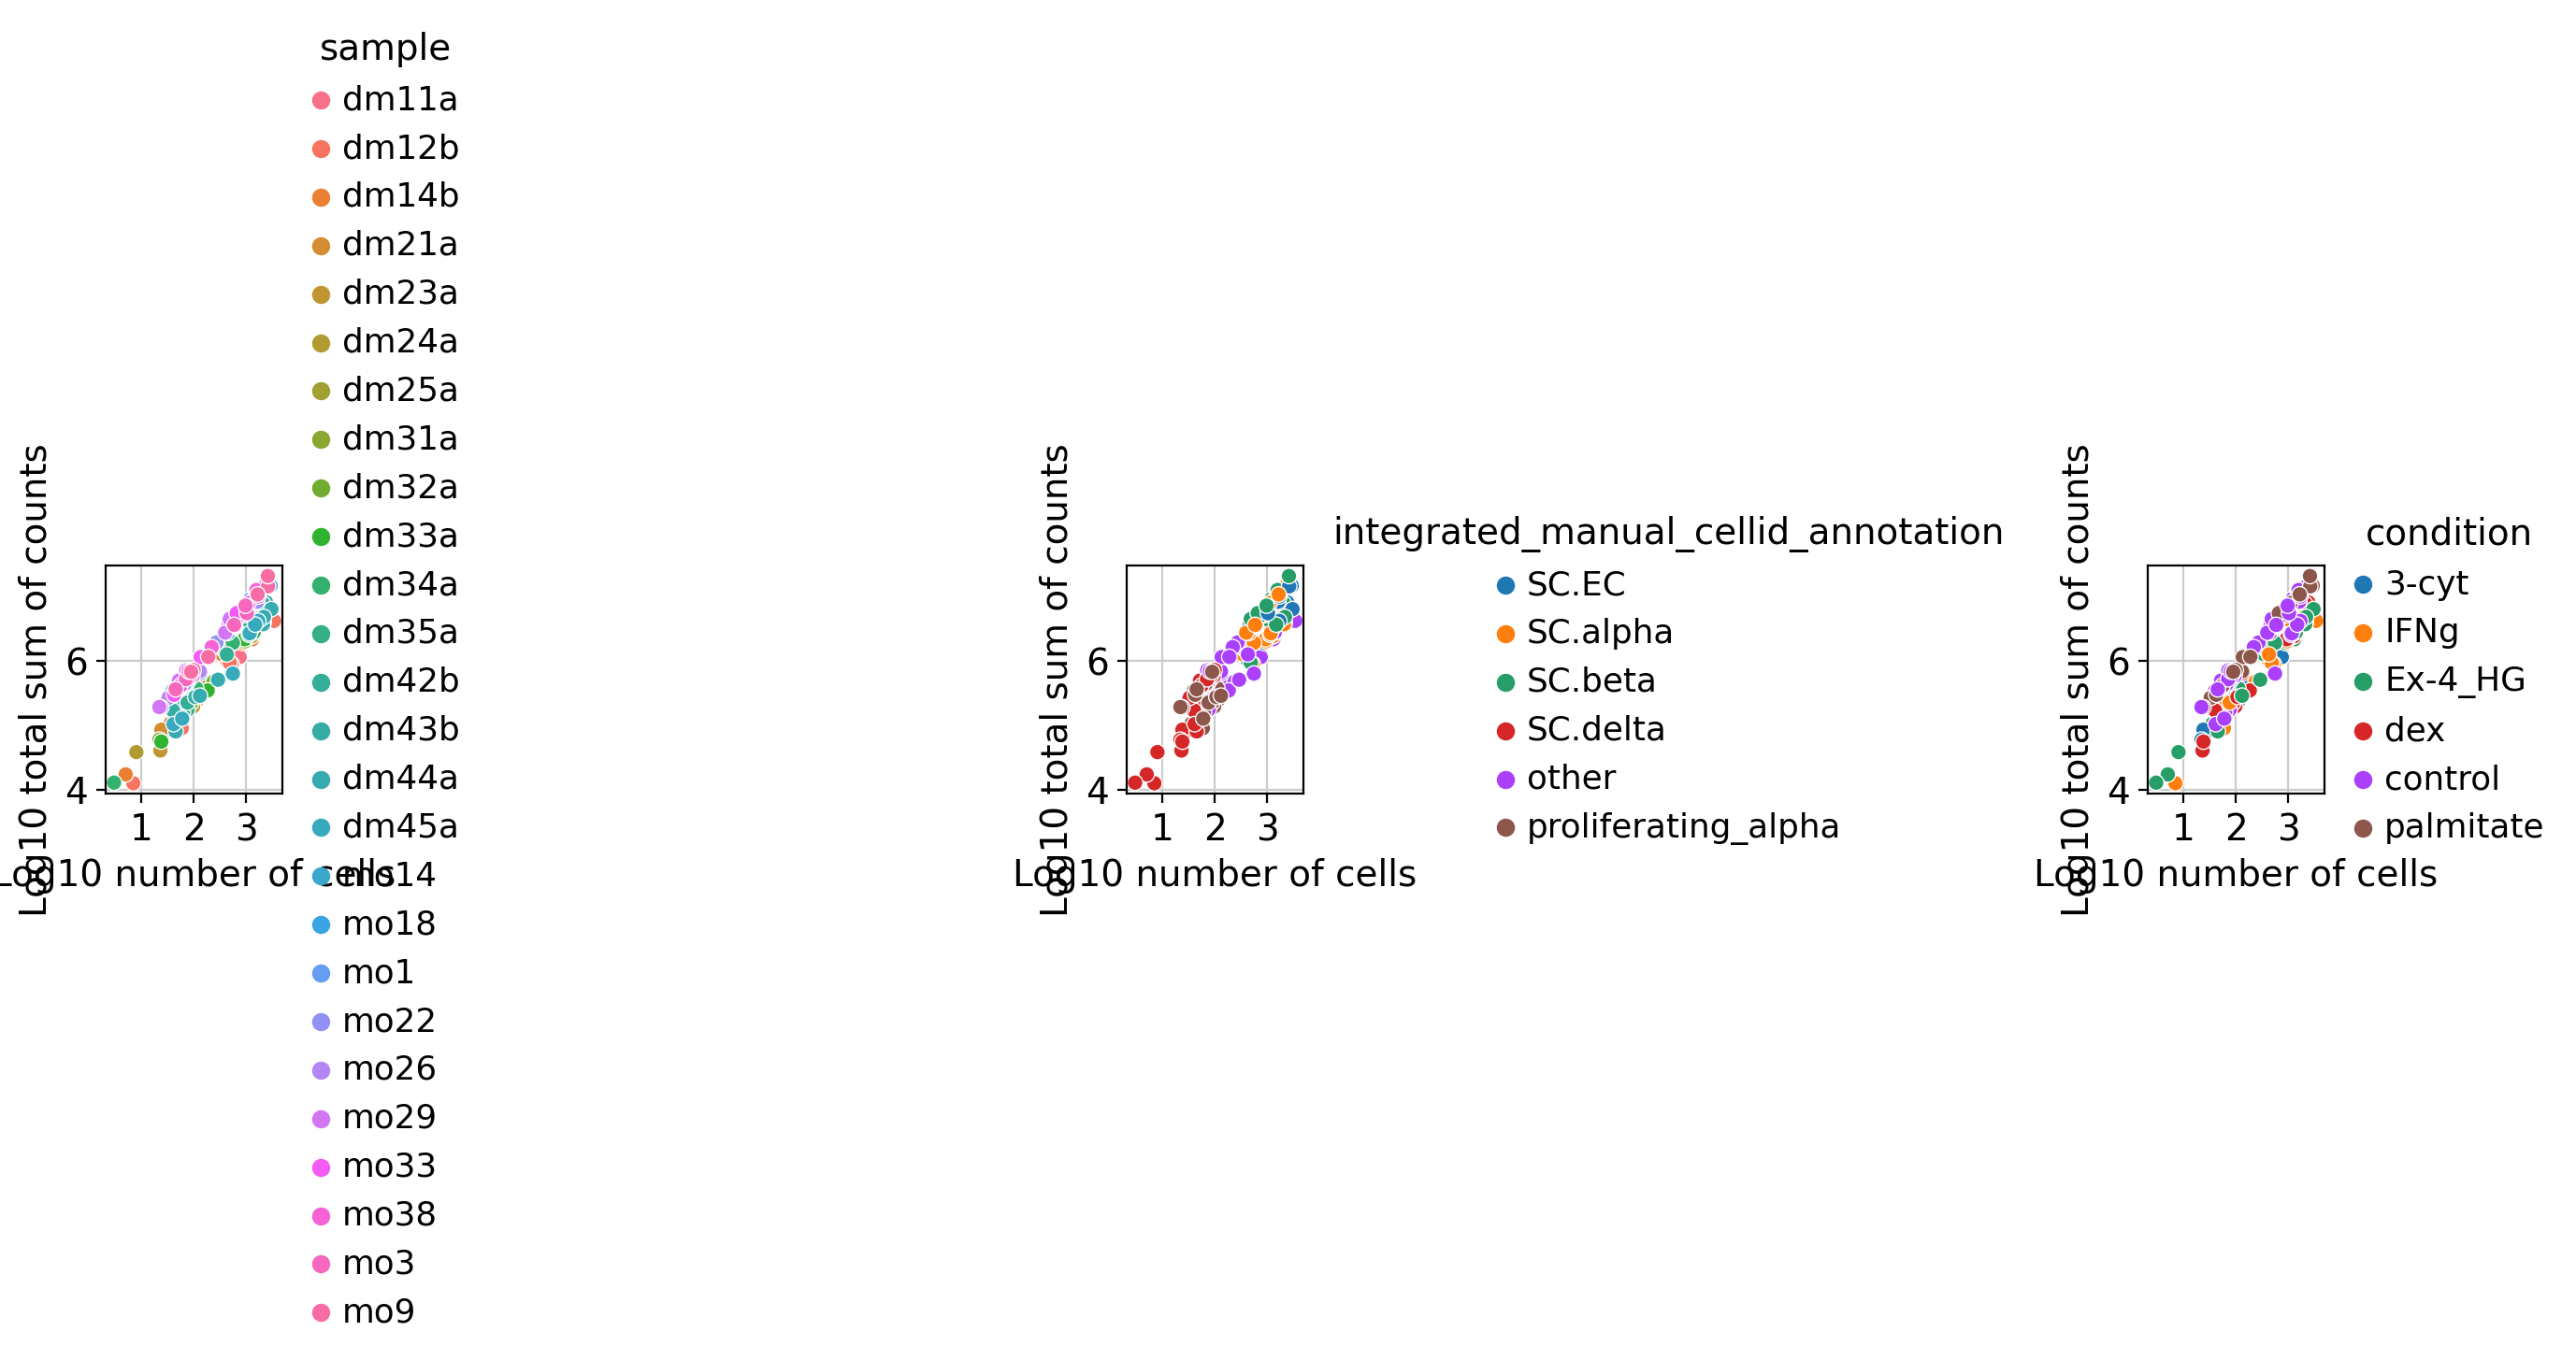

In [204]:
# Plot some QCs on the pseudo-bulk data
dc.plot_psbulk_samples(
    pdata, 
    groupby=groupby_keys,
    figsize=(14, 6), 
    save=os.path.join(outdir_path, "pseudobulk_samples_plot.png")
)

In [205]:
from pseudobulk import convert_object_in_obs

In [206]:
# Save just the normal pseudo-bulk
convert_object_in_obs(pdata)
pdata.write(os.path.join(outdir_path, "pdatas", "pseudobulk_no_filter.h5ad"))
pdata_df = pdata.to_df()
pdata_df.to_csv(os.path.join(outdir_path, "pdatas", "pseudobulk_no_filter.tsv"), sep="\t", index=True)

In [207]:
# Get pseudo-bulk profile WITH filtering
pdata = dc.get_pseudobulk(
    adata,
    sample_col=obs_key,
    groups_col=None,
    layer='counts',
    mode=mode,
    min_cells=min_cells,
    min_counts=min_counts
)

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


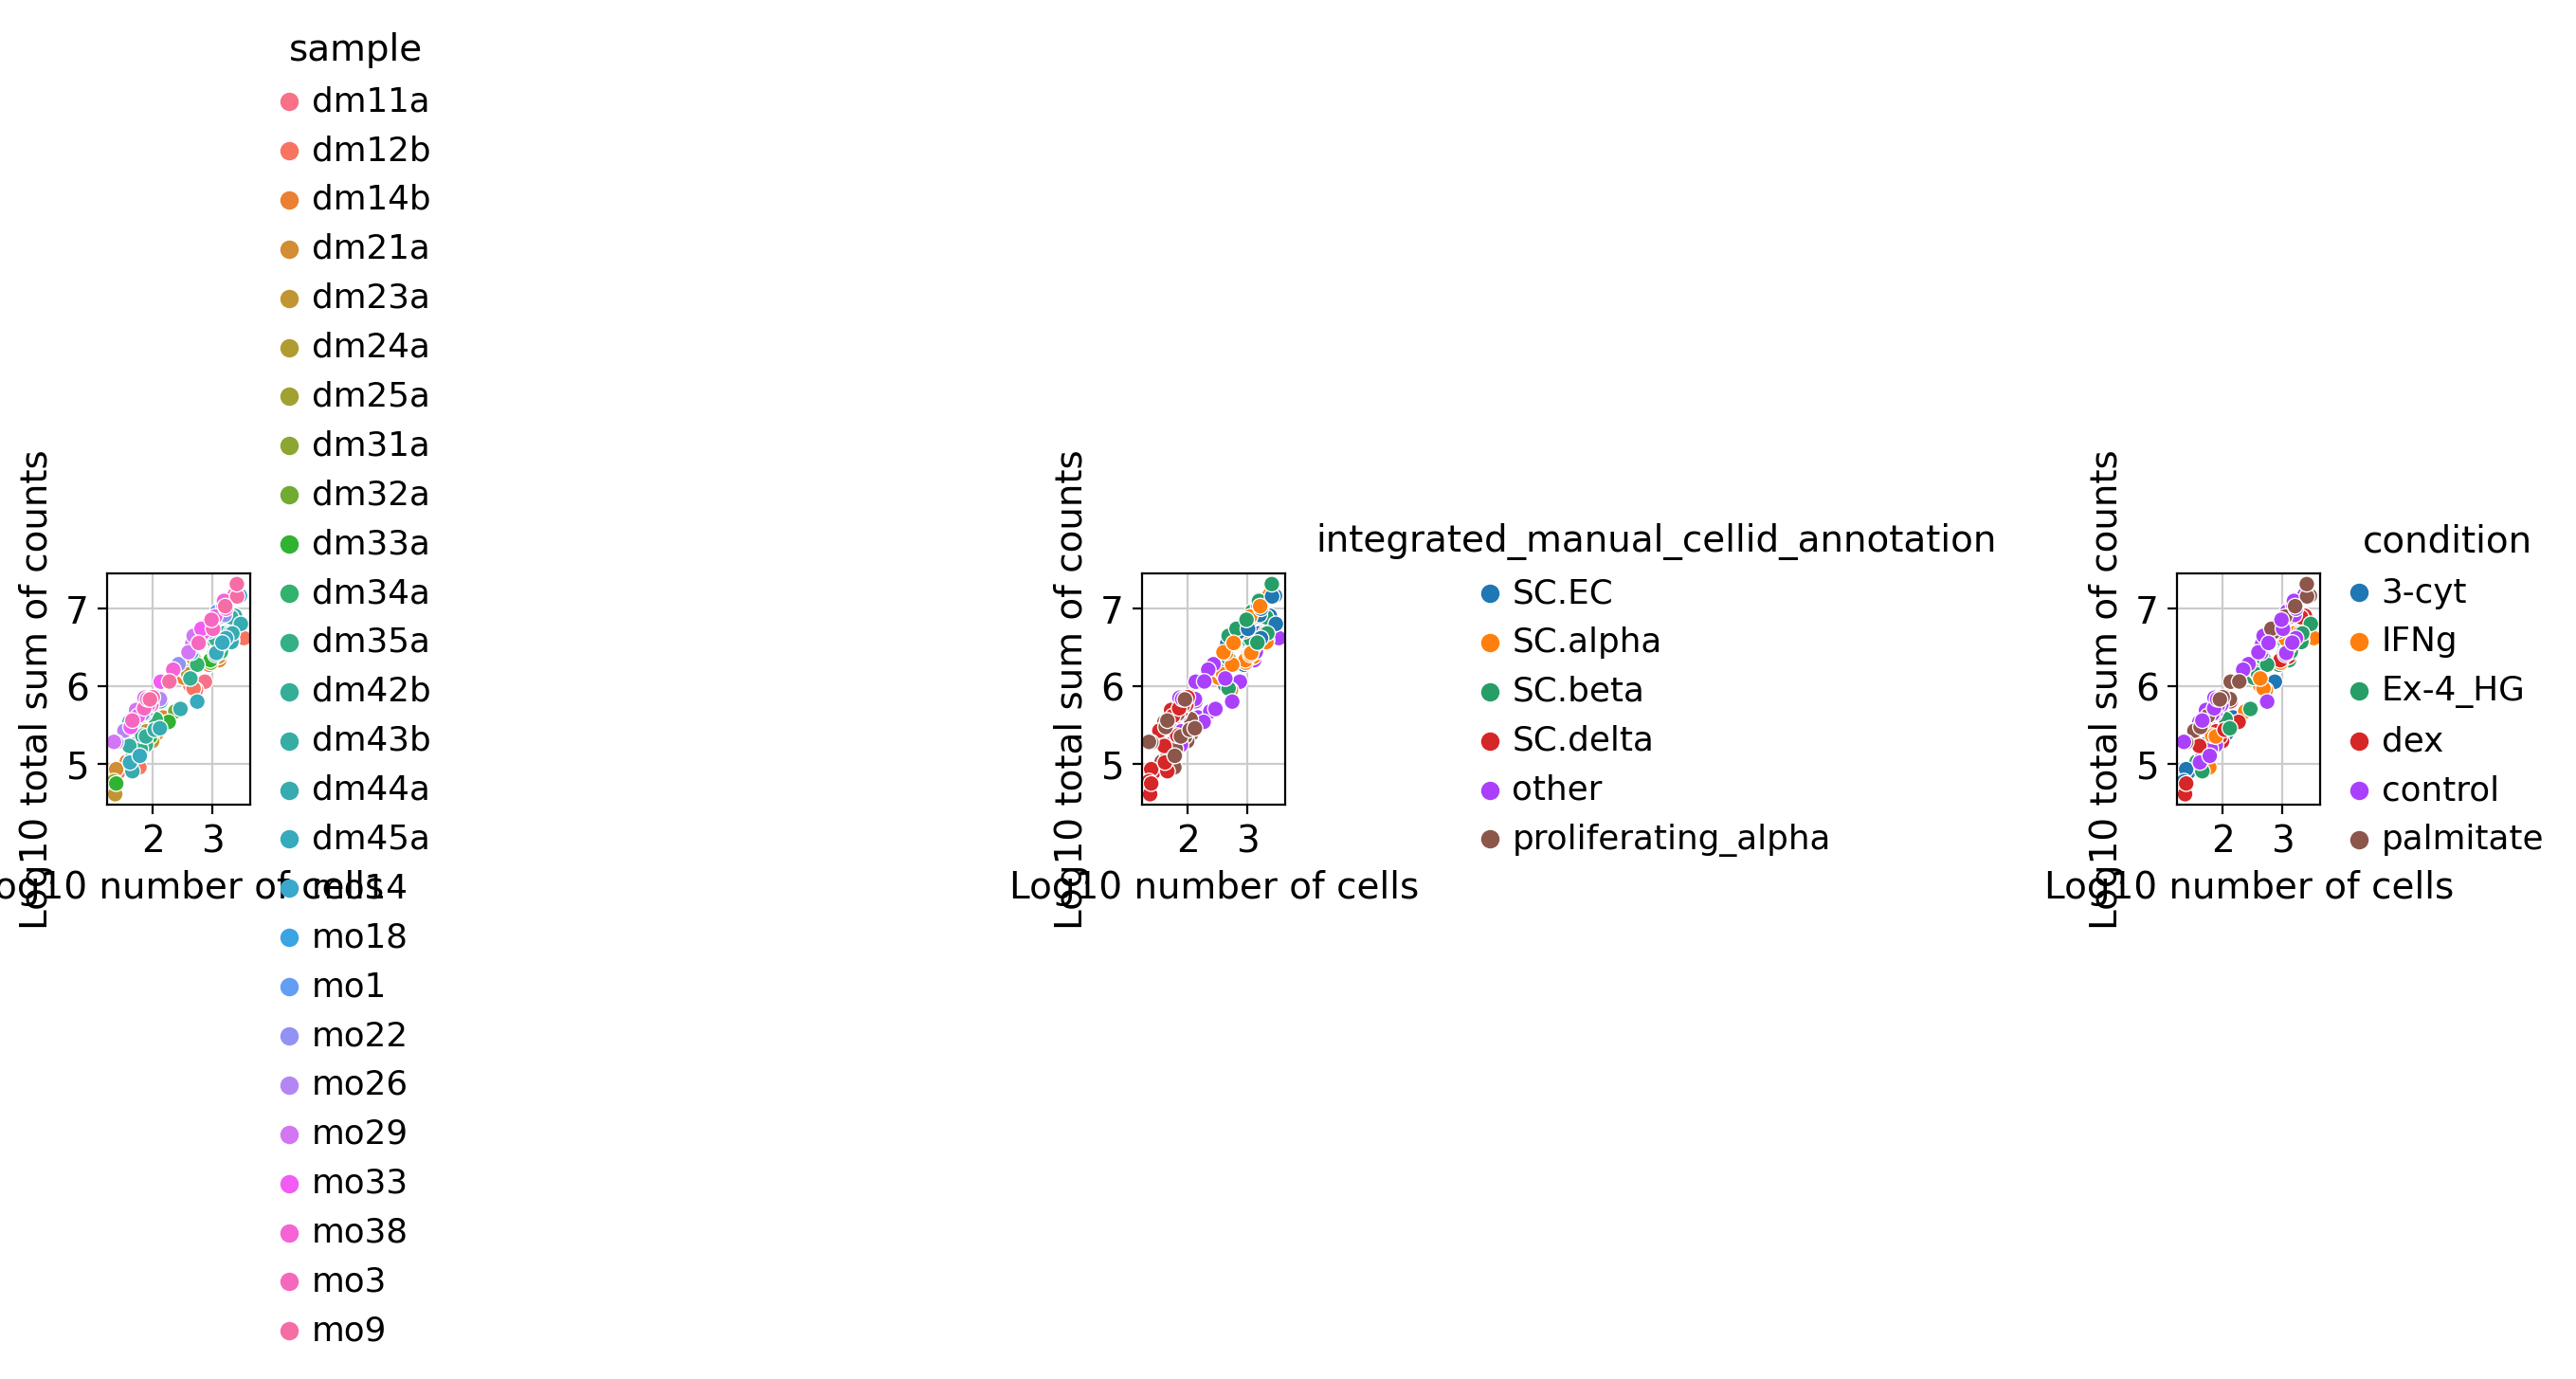

In [208]:
# Plot some QCs on the pseudo-bulk data
dc.plot_psbulk_samples(
    pdata, 
    groupby=groupby_keys,
    figsize=(14, 6),
    save=os.path.join(outdir_path, "pseudobulk_filtered_samples_plot.png")
)

In [209]:
# Save just the normal pseudo-bulk
convert_object_in_obs(pdata)
pdata.write(os.path.join(outdir_path, "pdatas", "pseudobulk_filter.h5ad"))
pdata_df = pdata.to_df()
pdata_df.to_csv(os.path.join(outdir_path, "pdatas", "pseudobulk_filter.tsv"), sep="\t", index=True)

# Explore the pseudobulk profiles

In [210]:
# Get a copy to process
pp_pdata = pdata.copy()

In [211]:
# CPM normalize
sc.pp.normalize_total(pp_pdata, target_sum=1e6)

normalizing counts per cell
    finished (0:00:00)


In [212]:
# log(1+p) transformation
sc.pp.log1p(pp_pdata)

In [213]:
pp_pdata.layers["log_cpm"] = pp_pdata.X.copy()

In [214]:
# Scale
sc.pp.scale(pp_pdata, max_value=10)

## PCA

In [215]:
# PCA
sc.tl.pca(pp_pdata, n_comps=10)

computing PCA
    with n_comps=10
    finished (0:00:00)


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/tmp/ipykernel_1553304/1636542909.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


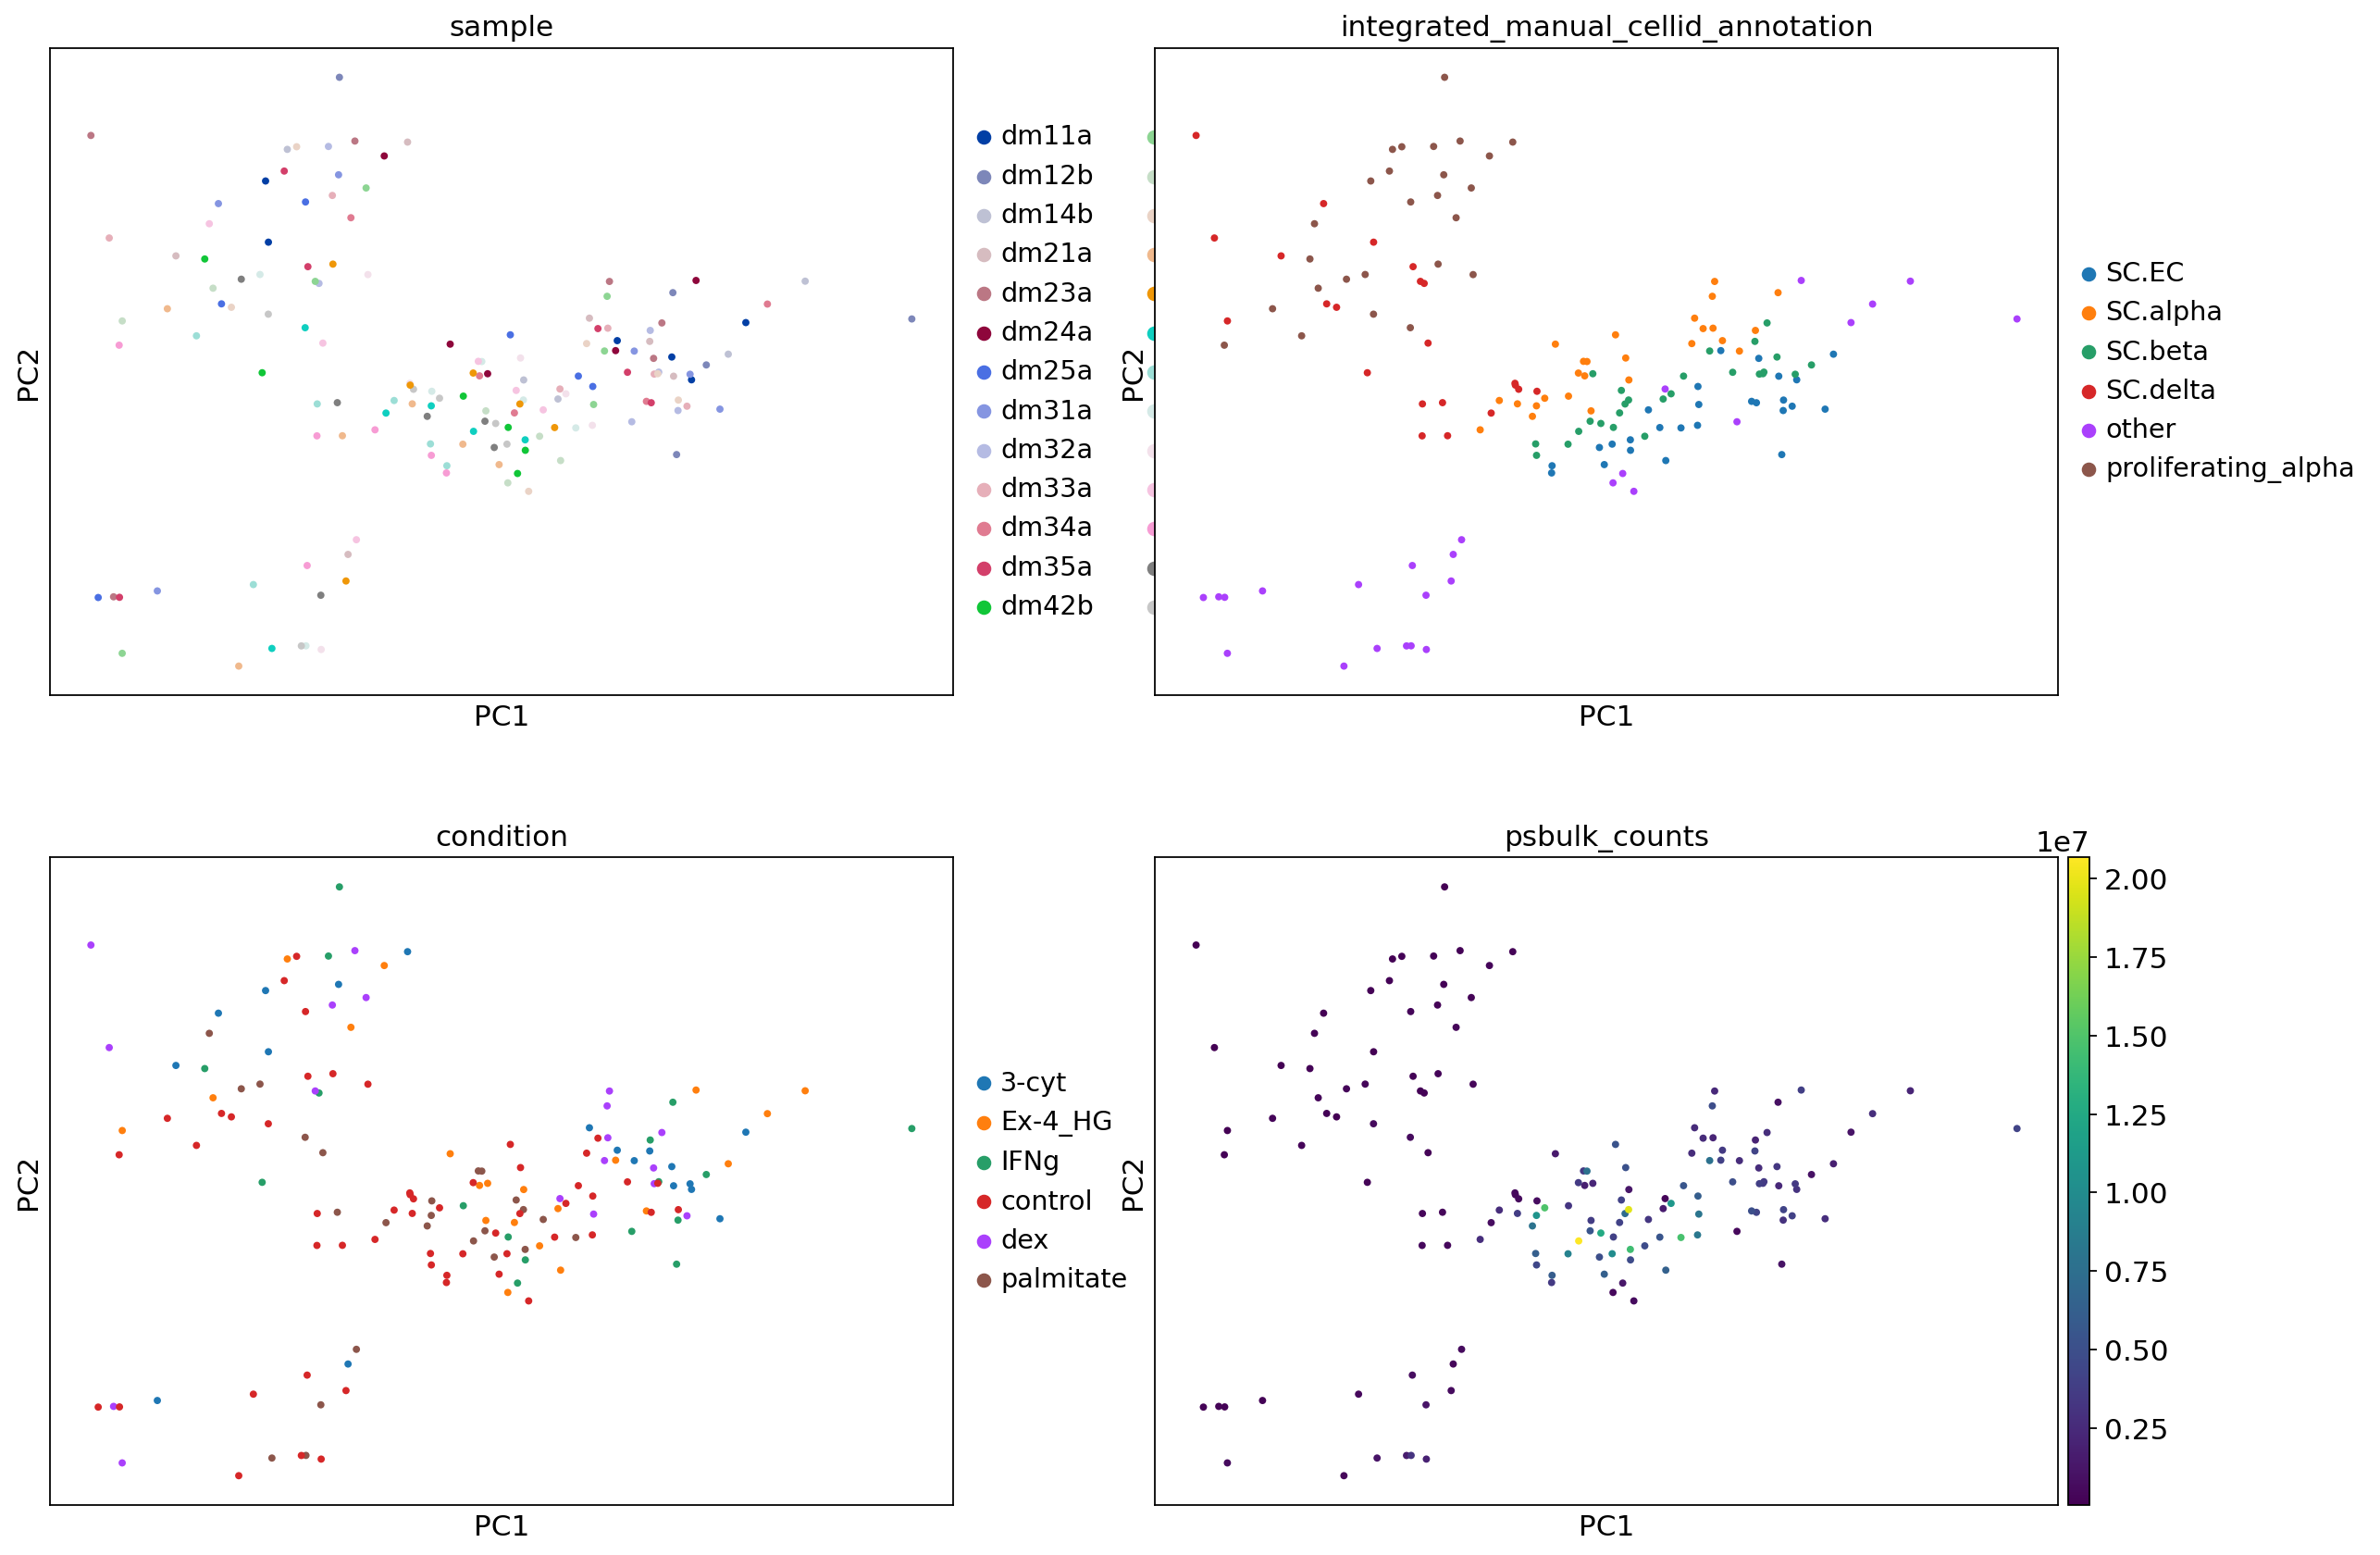

In [216]:
# Plot the PCA with covariates
with plt.rc_context({"figure.figsize": (8, 6)}):
    sc.pl.pca(pp_pdata, color=groupby_keys + ['psbulk_counts'], ncols=2, size=50, show=False)
    plt.savefig(os.path.join(outdir_path, "pca_w_covariates.png"))
    plt.tight_layout()
    plt.show()

In [217]:
# Get correlations with PCs
for groupby_key in groupby_keys:
    pp_pdata.obs[groupby_key] = pp_pdata.obs[groupby_key].str.replace(".", "_")
dc.get_metadata_associations(
    pp_pdata,
    obs_keys = groupby_keys + ['psbulk_n_cells', 'psbulk_counts'],  # metadata columns to associate to PCs
    obsm_key='X_pca',  # where the PCs are stored
    uns_key='pca_anova',  # where the results are stored
    inplace=True
)

/tmp/ipykernel_1553304/1066569911.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  pp_pdata.obs[groupby_key] = pp_pdata.obs[groupby_key].str.replace(".", "_")
100%|██████████| 10/10 [00:00<00:00, 38.72it/s]


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/PyComplexHeatmap/clustermap.py:803: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Starting plotting HeatmapAnnotations
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


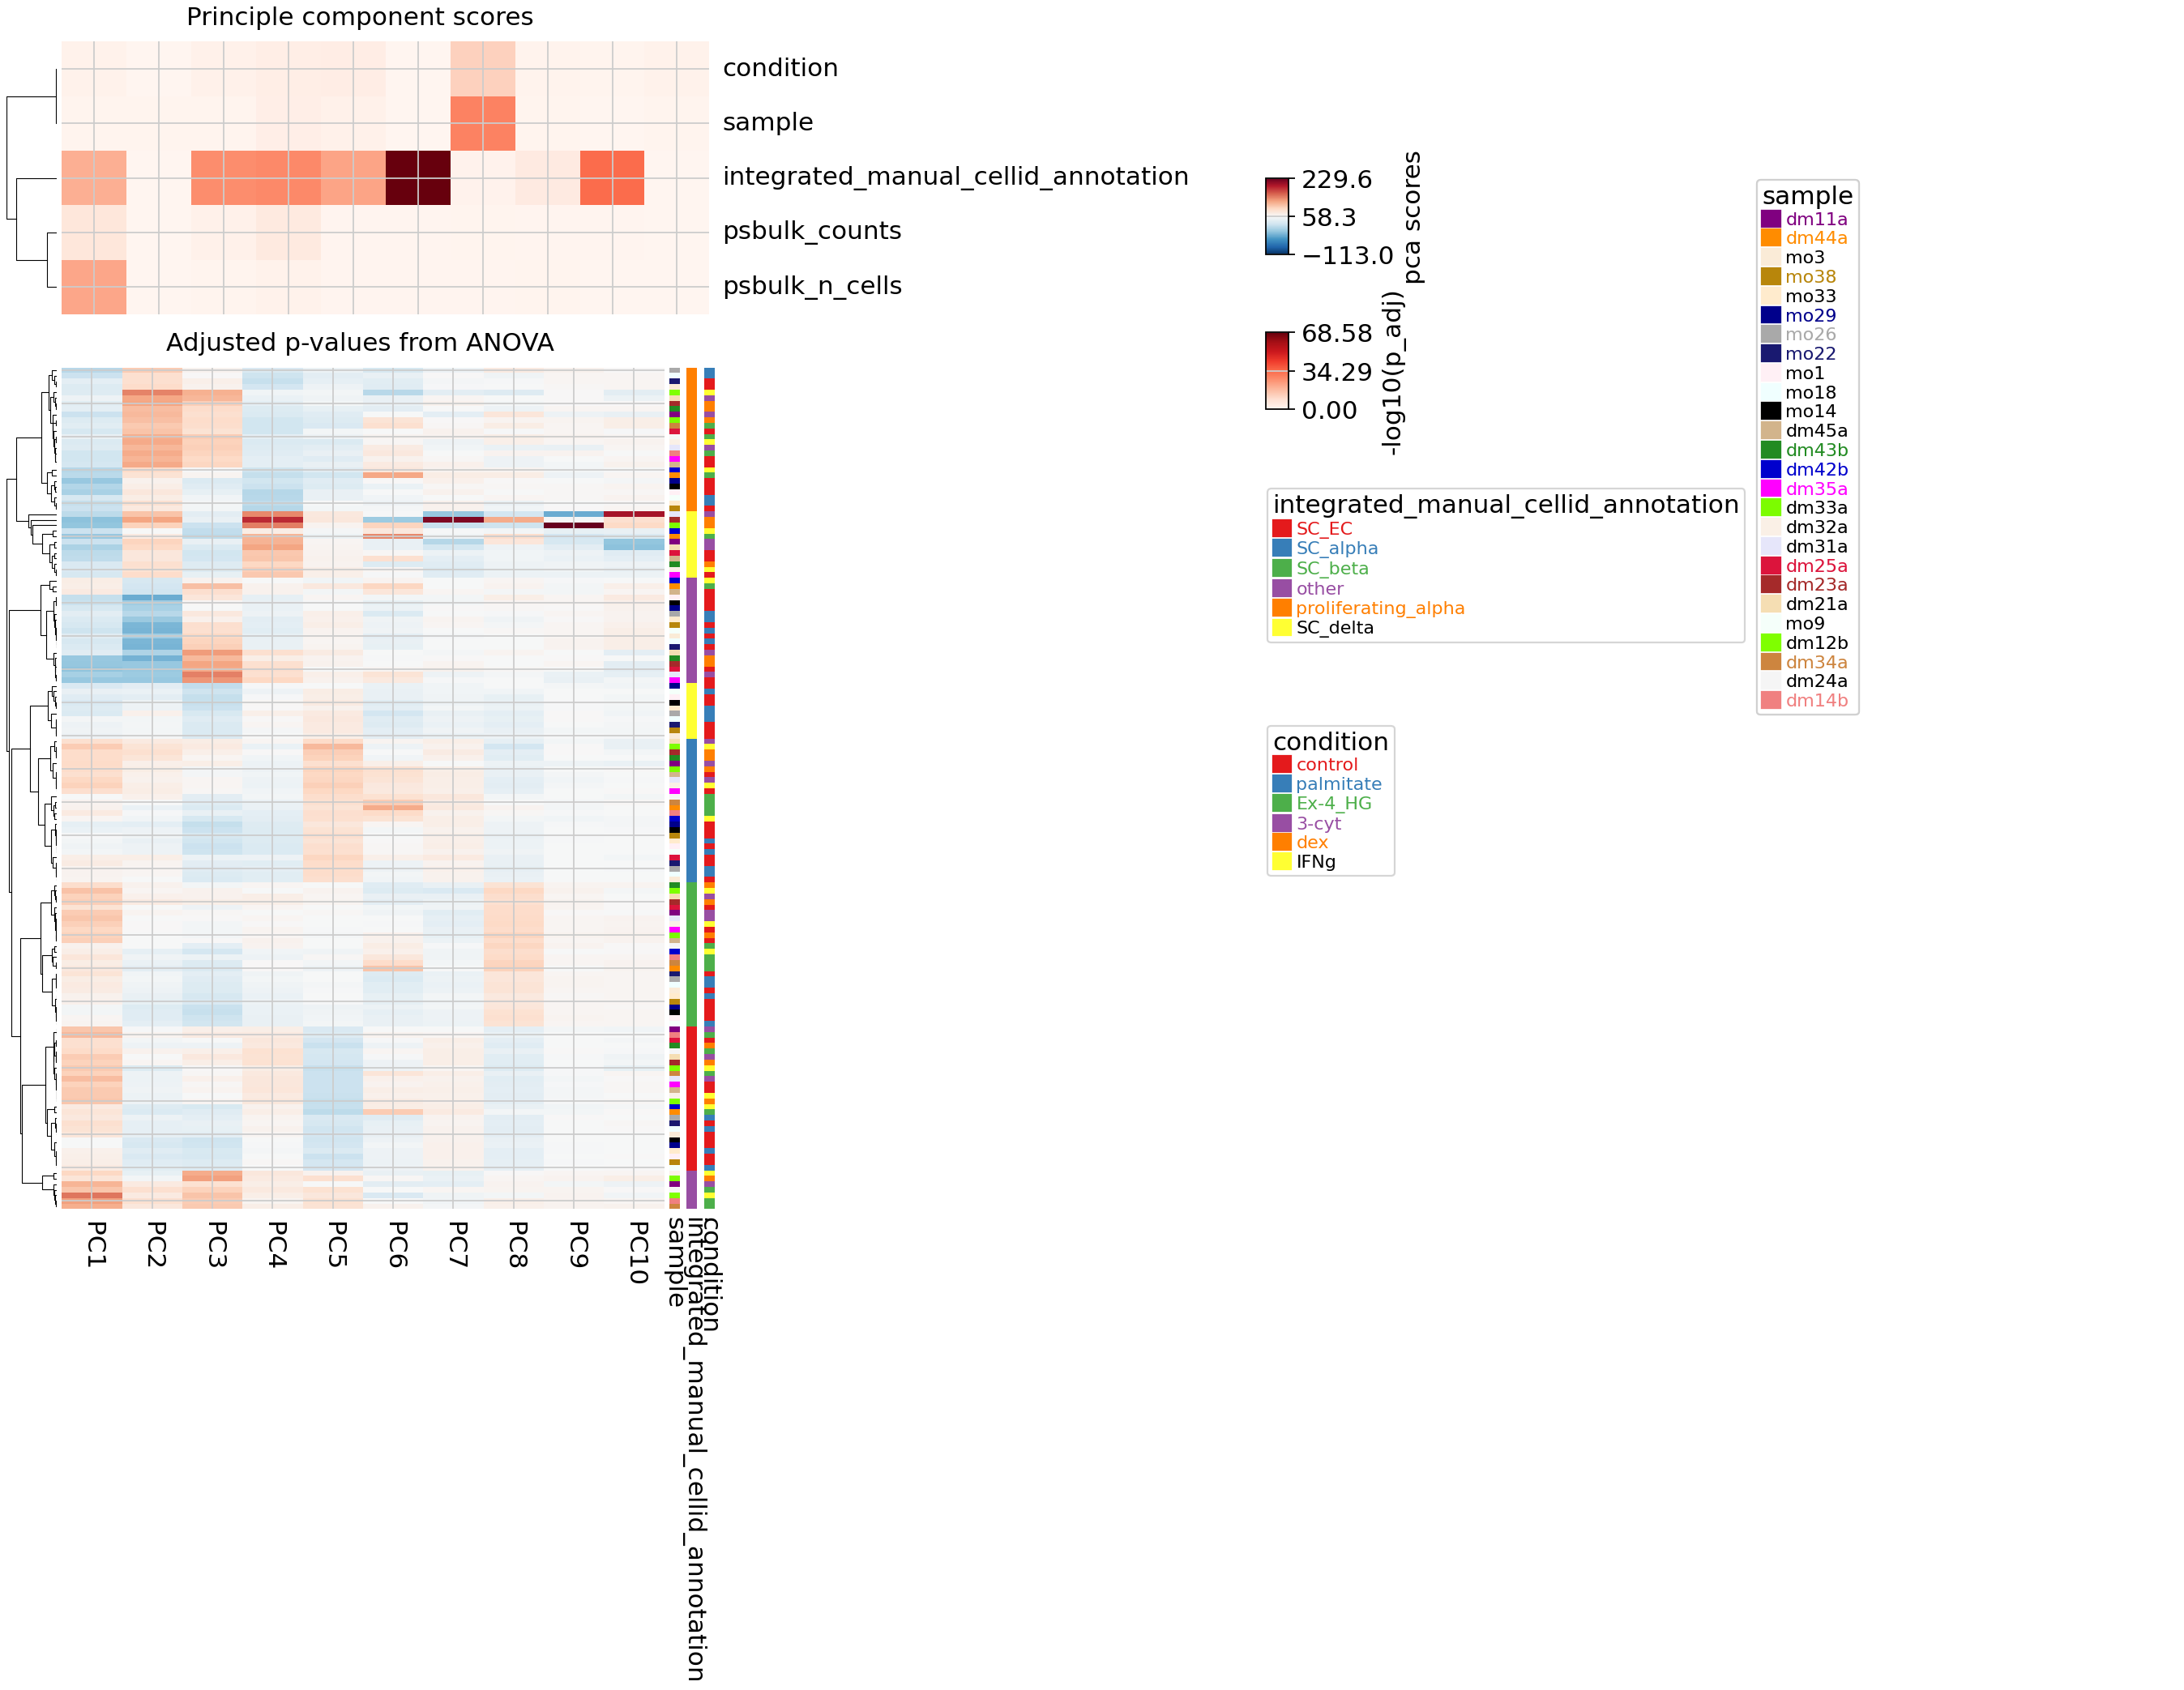

In [218]:
plt.figure(figsize=(7,10))
ax, legend_axes = dc.plot_associations(
    pp_pdata,
    uns_key='pca_anova',  # summary statistics from the anova tests
    obsm_key='X_pca',  # where the PCs are stored
    stat_col='p_adj',  # which summary statistic to plot
    obs_annotation_cols = groupby_keys,
    titles=['Adjusted p-values from ANOVA', 'Principle component scores'])  # which sample annotations to plot
plt.savefig(os.path.join(outdir_path, "ps_pc_assocation_anova.png"), bbox_inches='tight')
plt.show()

# Creating pseudobulk pdatas for DESeq2

In [219]:
if cellid_key and compare_key:
    assert cellid_key in groupby_keys, f"cellid_key {cellid_key} must be in groupby_keys {groupby_keys}"
    assert compare_key in groupby_keys, f"compare_key {compare_key} must be in groupby_keys {groupby_keys}"
    print(f"Creating pseudobulk h5ads for each {cellid_key} to make DE comparisons for {compare_key}")
    
    for cellid, cell_barcodes in pdata.obs.groupby(cellid_key).groups.items():
        print(f"Selecting pseudobulks {cellid}")
        # Select profiles of interest
        pdata_deseq = pdata[cell_barcodes, :].copy()

        # Obtain genes that pass the thresholds
        genes = dc.filter_by_expr(pdata_deseq, group=compare_key, min_count=10, min_total_count=15)

        # Filter by these genes
        pdata_deseq = pdata_deseq[:, genes].copy()

        # Print the number of genes and samples
        print(f"Group: {cellid}")
        print(f"Genes: {pdata_deseq.n_vars}")
        print(f"Samples: {pdata_deseq.n_obs}")
        print("Samples in each group:")
        print(pdata_deseq.obs[compare_key].value_counts().to_string())

        # Save the object
        pdata_deseq.write(os.path.join(outdir_path, "pdatas", f"pseudobulk_{cellid}_filtered_genes.h5ad"))
        pdata_deseq_df = pdata_deseq.to_df()
        pdata_deseq_df.to_csv(os.path.join(outdir_path, "pdatas", f"pseudobulk_{cellid}_filtered_genes.tsv"), sep="\t", index=True)

Creating pseudobulk h5ads for each integrated_manual_cellid_annotation to make DE comparisons for condition
Selecting pseudobulks SC.EC
Group: SC.EC
Genes: 16628
Samples: 26
Samples in each group:
control      9
Ex-4_HG      4
palmitate    4
3-cyt        3
IFNg         3
dex          3
Selecting pseudobulks SC.alpha
Group: SC.alpha
Genes: 15416
Samples: 26
Samples in each group:
control      9
Ex-4_HG      4
palmitate    4
3-cyt        3
IFNg         3
dex          3
Selecting pseudobulks SC.beta
Group: SC.beta
Genes: 16566
Samples: 26
Samples in each group:
control      9
Ex-4_HG      4
palmitate    4
3-cyt        3
IFNg         3
dex          3
Selecting pseudobulks SC.delta
Group: SC.delta
Genes: 7932
Samples: 22
Samples in each group:
control      9
palmitate    4
3-cyt        3
dex          3
IFNg         2
Ex-4_HG      1
Selecting pseudobulks other
Group: other
Genes: 11816
Samples: 26
Samples in each group:
control      9
Ex-4_HG      4
palmitate    4
3-cyt        3
IFNg        

# DONE!

---

# Scratch

# Check INS expression at pseudobulk level

In [220]:
marker_genes_df = pd.read_csv("/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/ref/18Oct23/SC.islet.marker_genes.csv")
marker_genes_df.head()

,gene,cell_id
0,INS,SC.beta
1,IAPP,SC.beta
2,PDX1,SC.beta
3,GCG,SC.alpha
4,ARX,SC.alpha


In [221]:
# Now do the reverse: create a dictionary with cell_id as key and genes as a list of values
marker_genes_dict = marker_genes_df.groupby("cell_id")["gene"].apply(list).to_dict()
marker_genes_dict

{'SC.EC': ['TPH1', 'SLC18A1'],
 'SC.alpha': ['GCG', 'ARX'],
 'SC.beta': ['INS', 'IAPP', 'PDX1'],
 'SC.delta': ['SST', 'HHEX'],
 'endocrine_progenitor': ['ZEB2', 'NEUROG3', 'FEV'],
 'pancreatic_progenitor': ['SOX9', 'ONECUT1', 'KRT19'],
 'proliferating_alpha': ['MKI67']}

In [222]:
# Check markers against adata.var
marker_genes_in_data = dict()
for ct, markers in marker_genes_dict.items():
    markers_found = list()
    for marker in markers:
        if marker in pdata.var.index:
            markers_found.append(marker)
    marker_genes_in_data[ct] = markers_found

# Remove any keys with lists of length 0
marker_genes_in_data = {k: v for k, v in marker_genes_in_data.items() if len(v) > 0}
marker_genes_in_data

{'SC.EC': ['TPH1', 'SLC18A1'],
 'SC.alpha': ['GCG', 'ARX'],
 'SC.beta': ['INS', 'IAPP', 'PDX1'],
 'SC.delta': ['SST', 'HHEX'],
 'endocrine_progenitor': ['ZEB2', 'NEUROG3', 'FEV'],
 'pancreatic_progenitor': ['SOX9', 'ONECUT1', 'KRT19'],
 'proliferating_alpha': ['MKI67']}

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


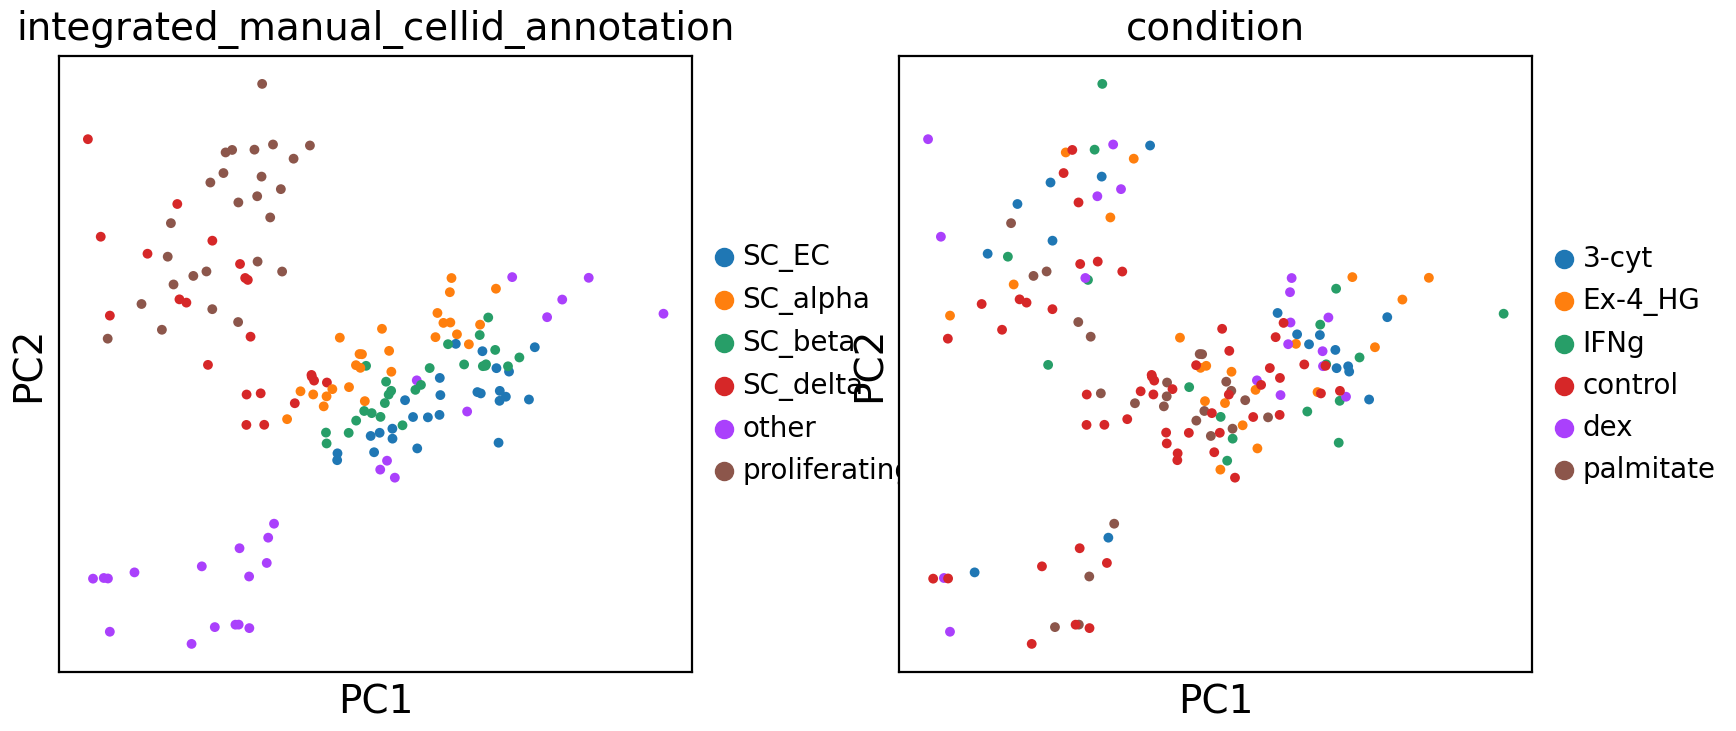

In [223]:
sc.pl.pca(
        adata=pp_pdata,
        color=["integrated_manual_cellid_annotation", "condition"],
        layer="log_cpm",
        vmin=0,
        size=50,
        sort_order=False,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
        #frameon=False,
    )

SC.EC:


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


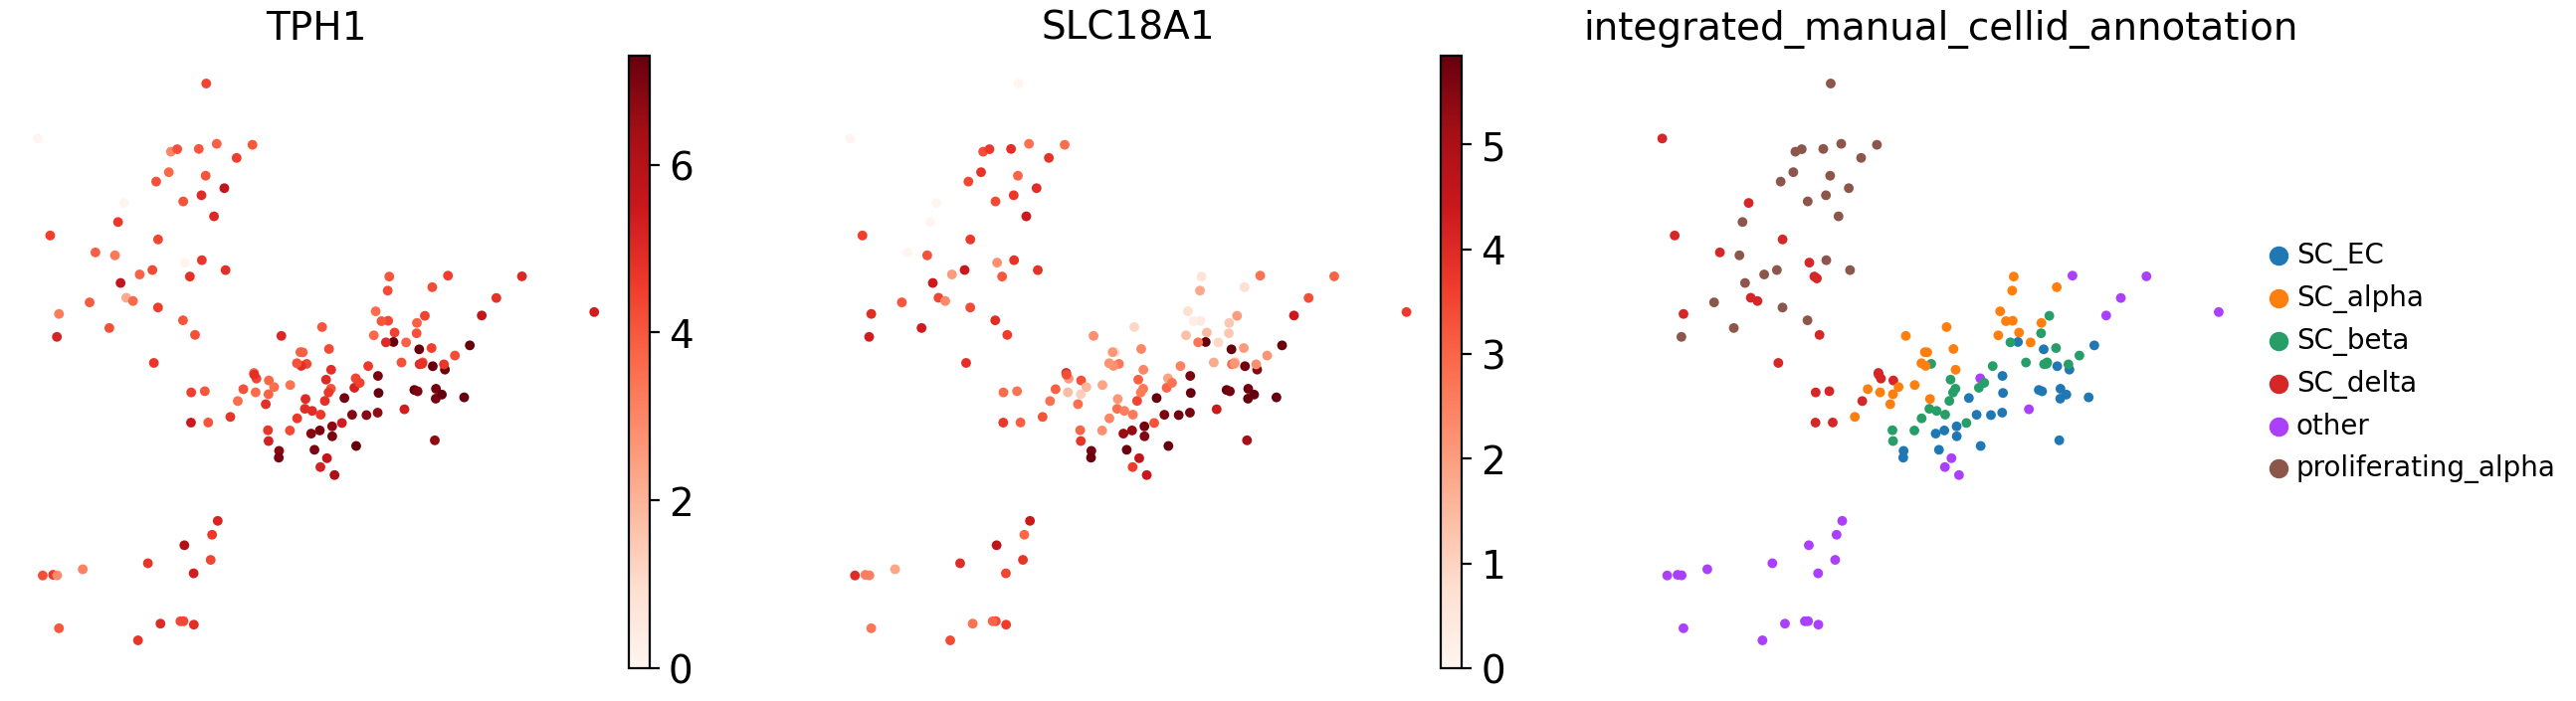





SC.ALPHA:


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


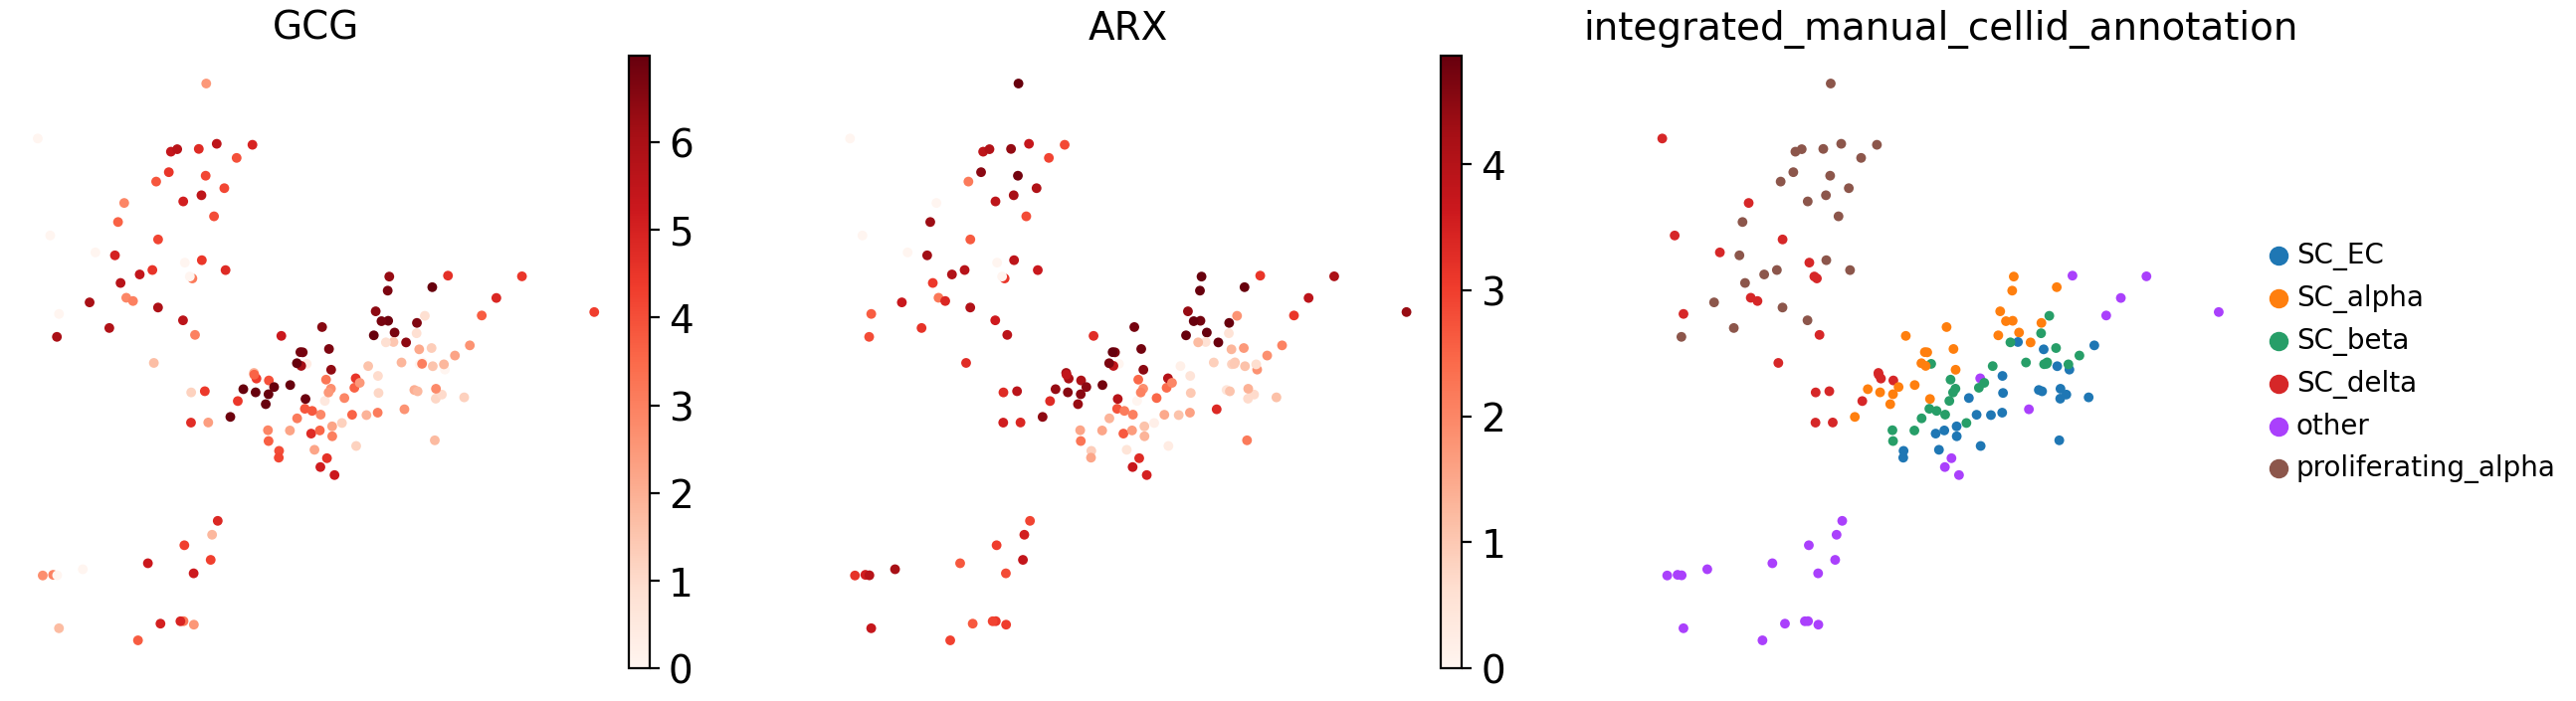





SC.BETA:


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


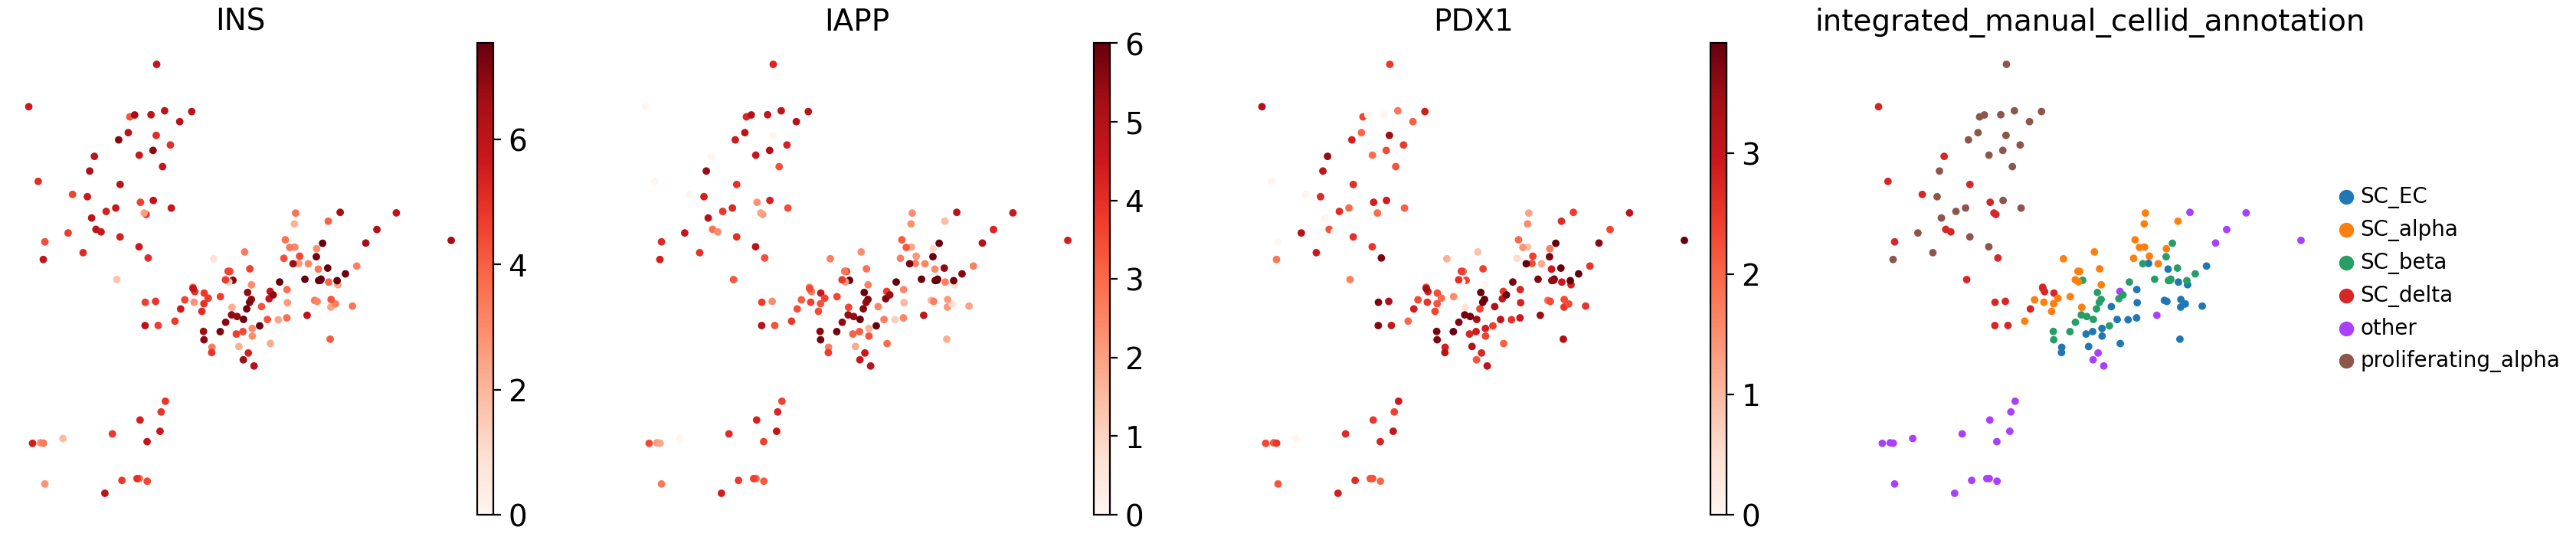





SC.DELTA:


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


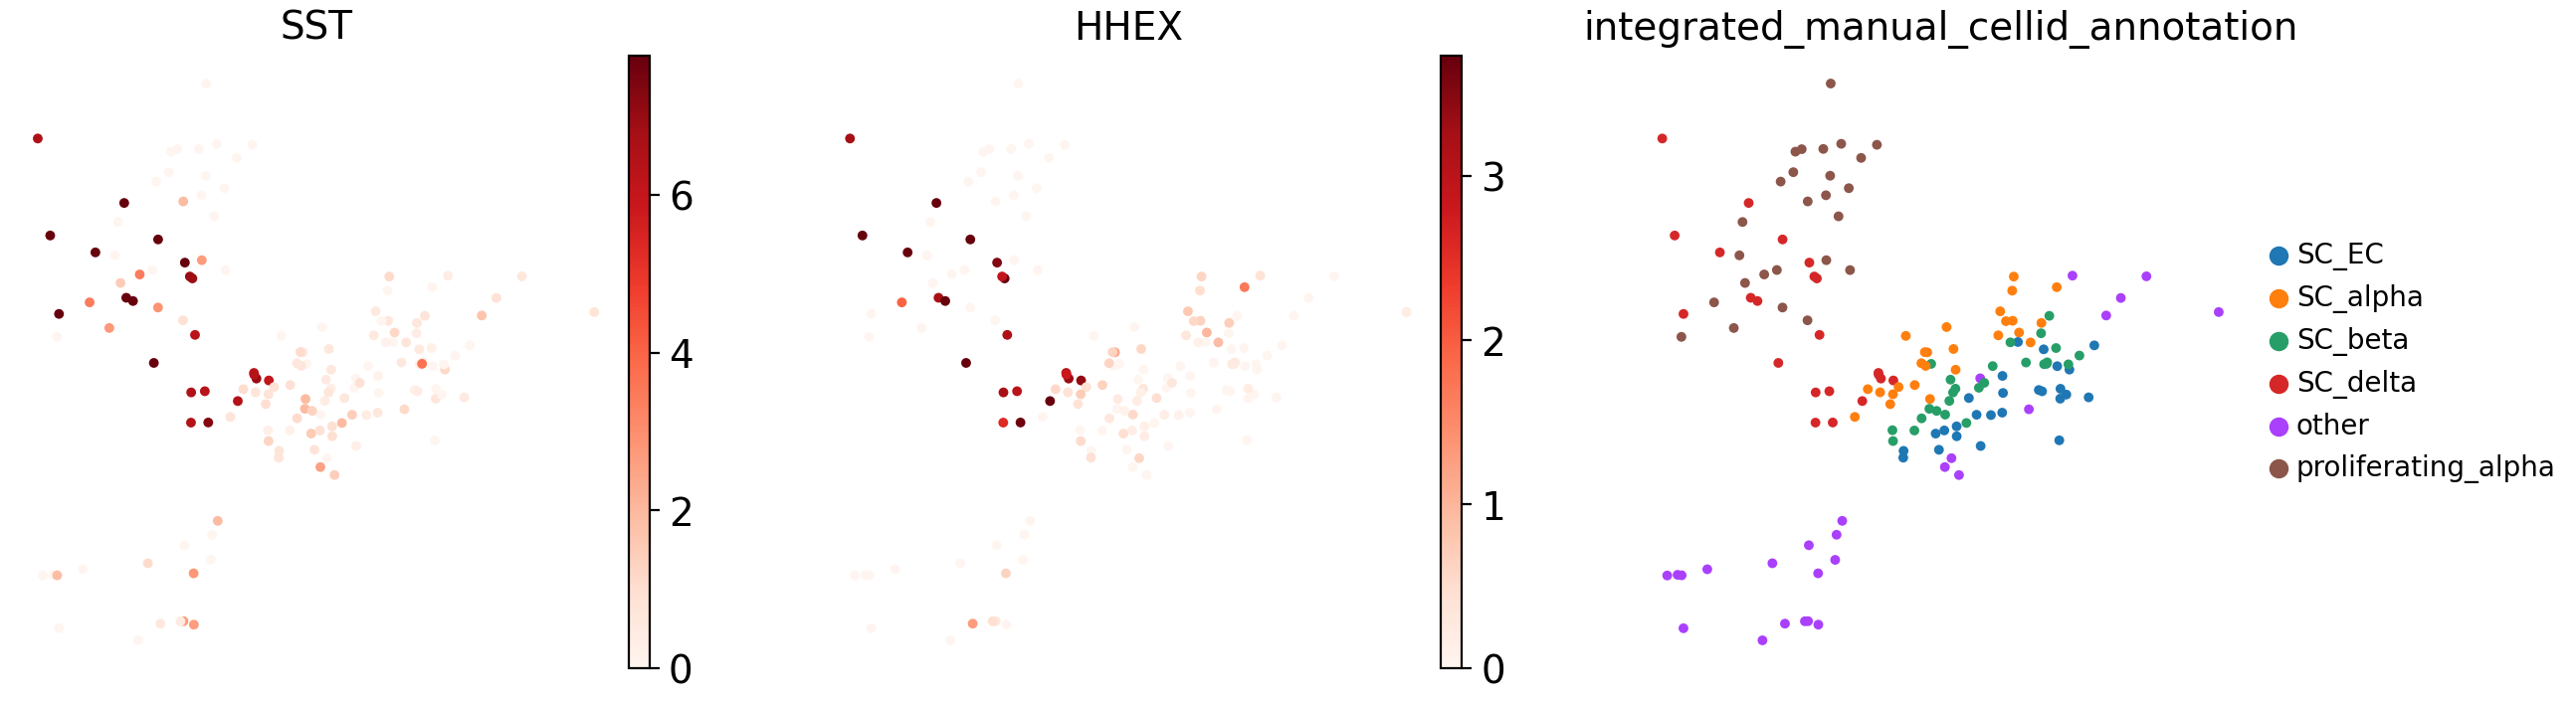





ENDOCRINE_PROGENITOR:


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


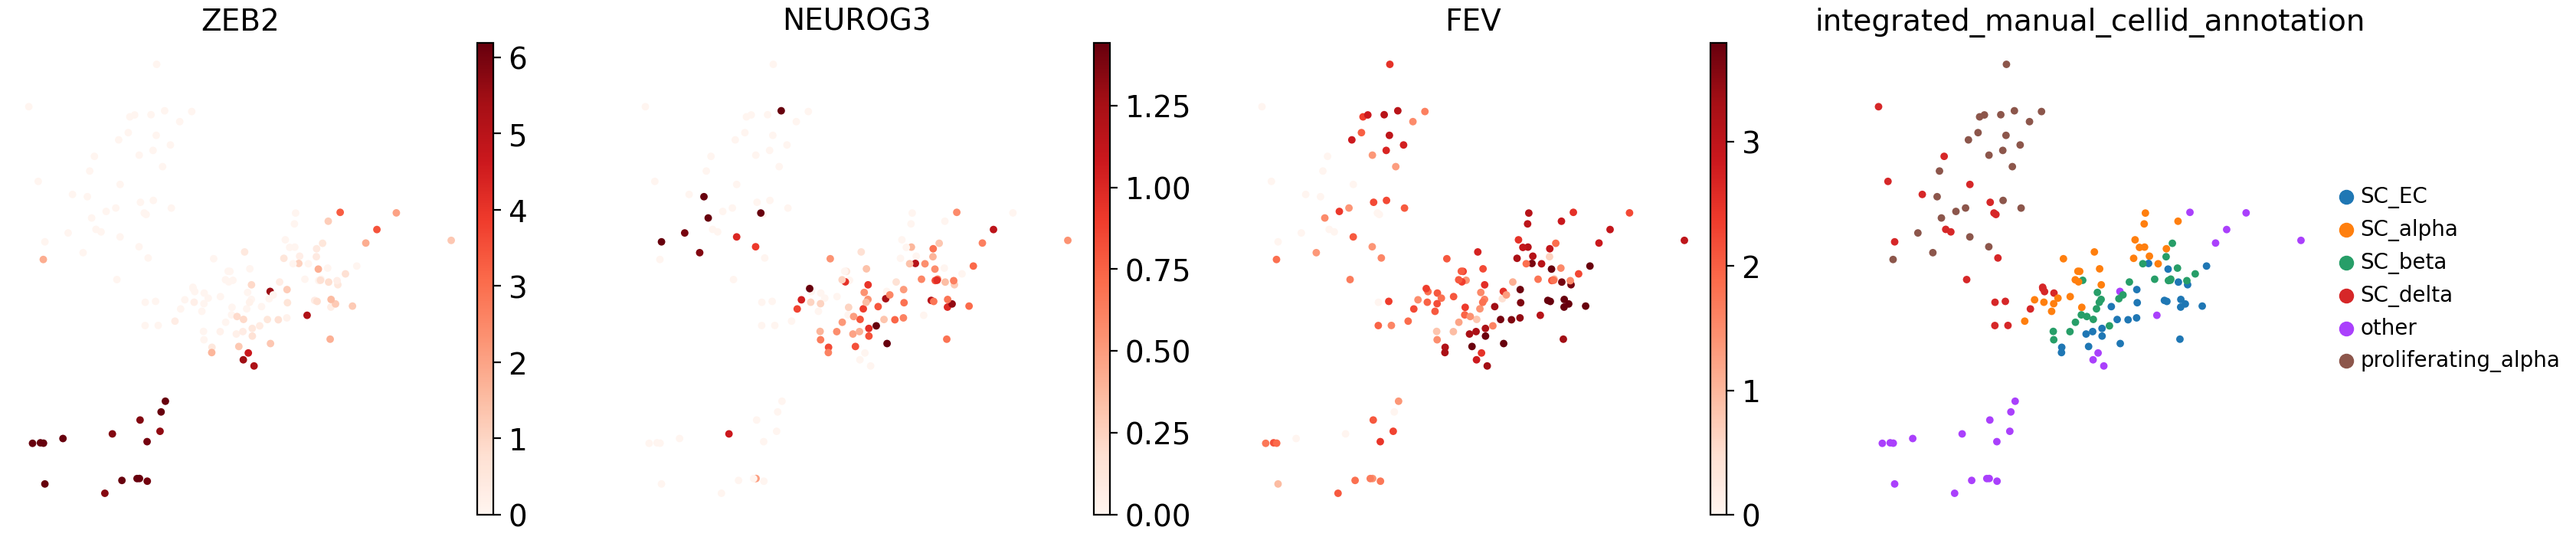





PANCREATIC_PROGENITOR:


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


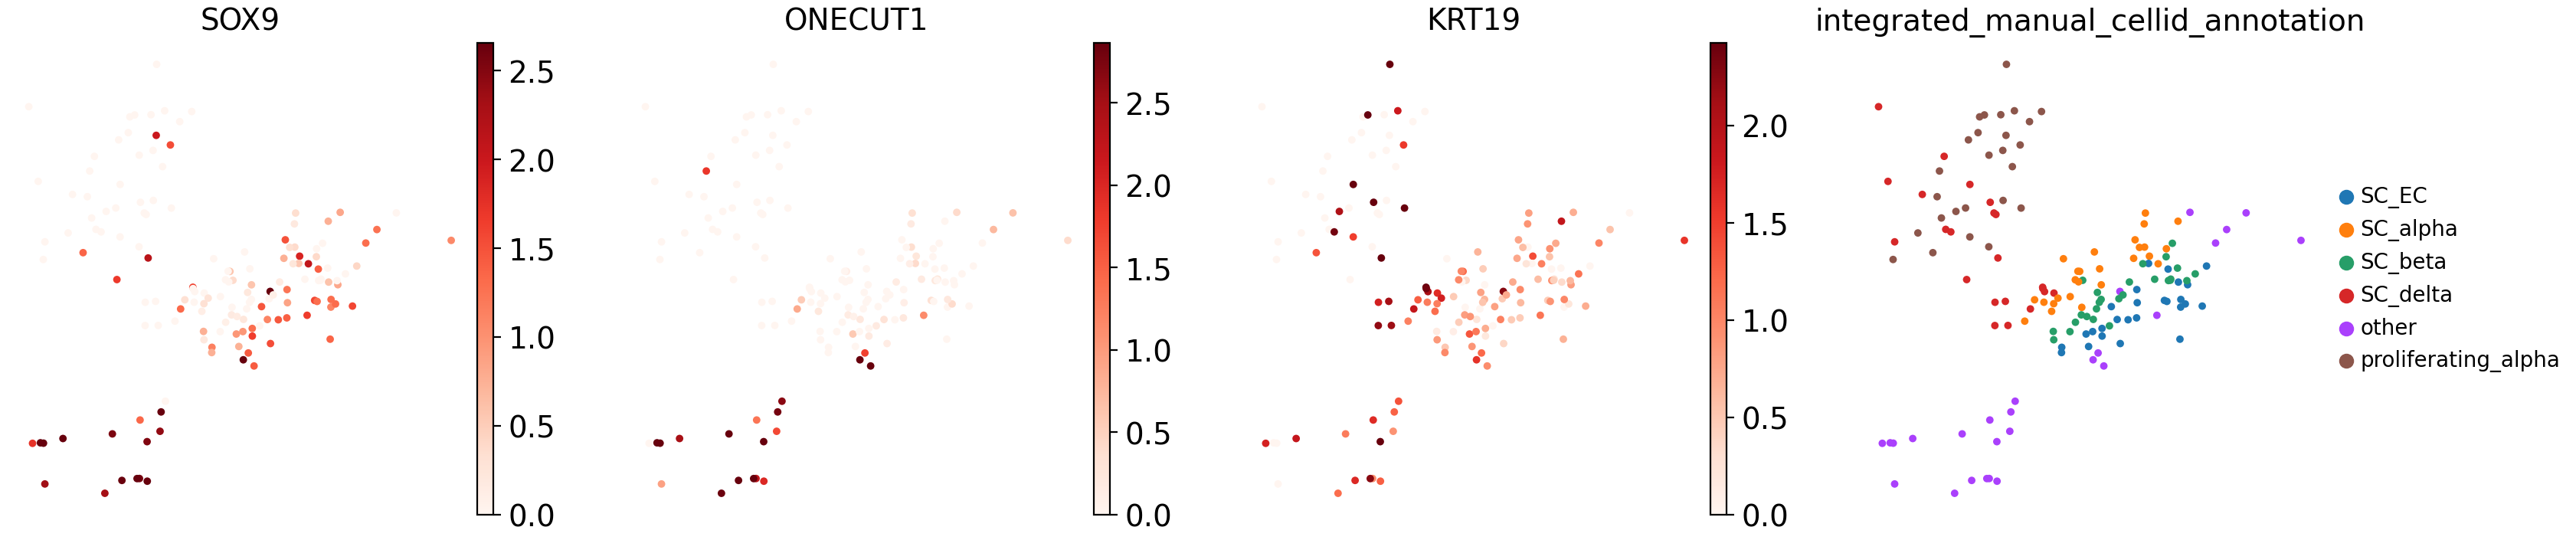





PROLIFERATING_ALPHA:


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


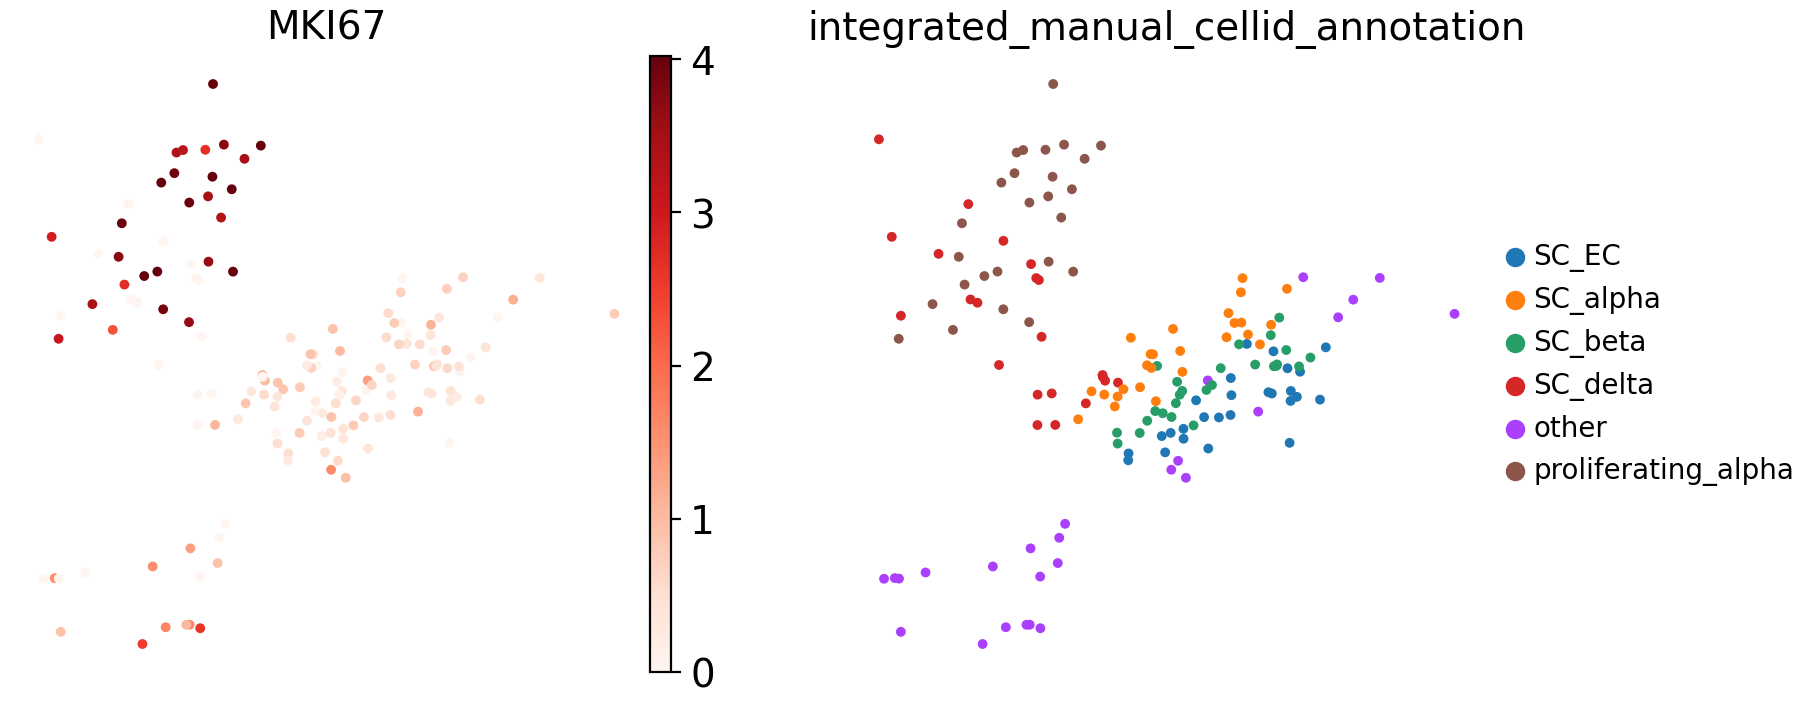

In [224]:
for ct in marker_genes_in_data.keys():
    print(f"{ct.upper()}:")  # print cell subtype name
    sc.pl.pca(
        adata=pp_pdata,
        color=marker_genes_in_data[ct]+["integrated_manual_cellid_annotation"],
        layer="log_cpm",
        size=50,
        vmin=0,
        vmax="p95.0",  # set vmax to the 99th percentile of the gene count instead of the maximum, to prevent outliers from making expression in other cells invisible. Note that this can cause problems for extremely lowly expressed genes.
        sort_order=False,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
        frameon=False,
        cmap="Reds",  # or choose another color map e.g. from here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
    )
    print("\n\n\n")  # print white space for legibility

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


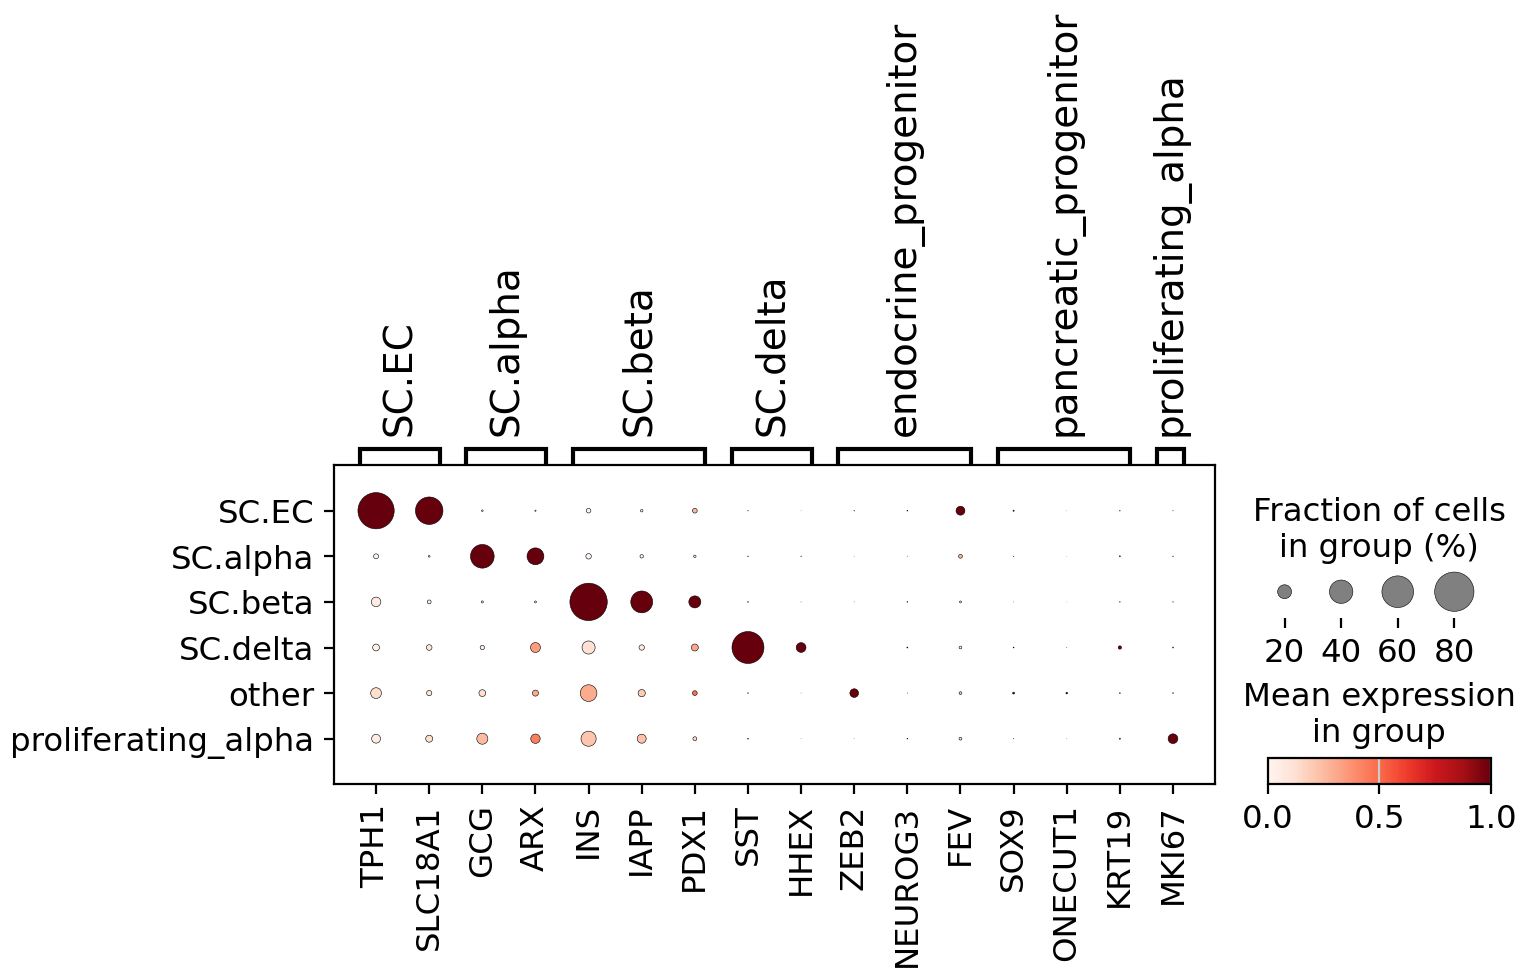

In [225]:
sc.pl.dotplot(
    adata,
    layer="log1p_norm",
    groupby="integrated_manual_cellid_annotation",
    var_names=marker_genes_in_data,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
)

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


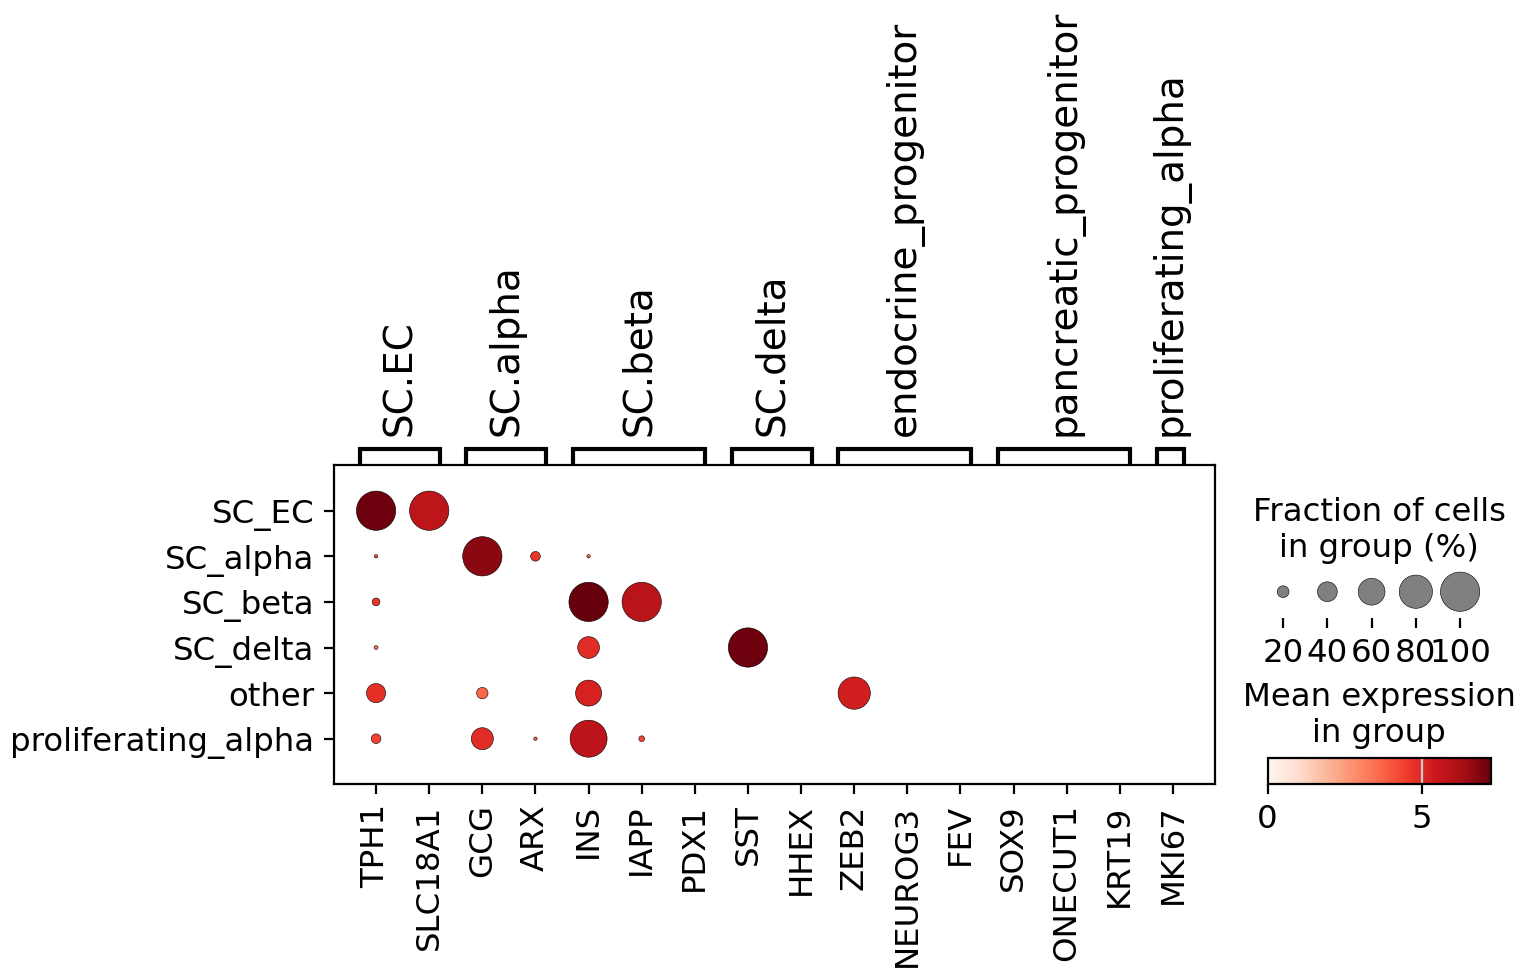

In [226]:
sc.pl.dotplot(
    pp_pdata,
    groupby="integrated_manual_cellid_annotation",
    var_names=marker_genes_in_data,
    layer="log_cpm",
    #standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    expression_cutoff=5
)

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


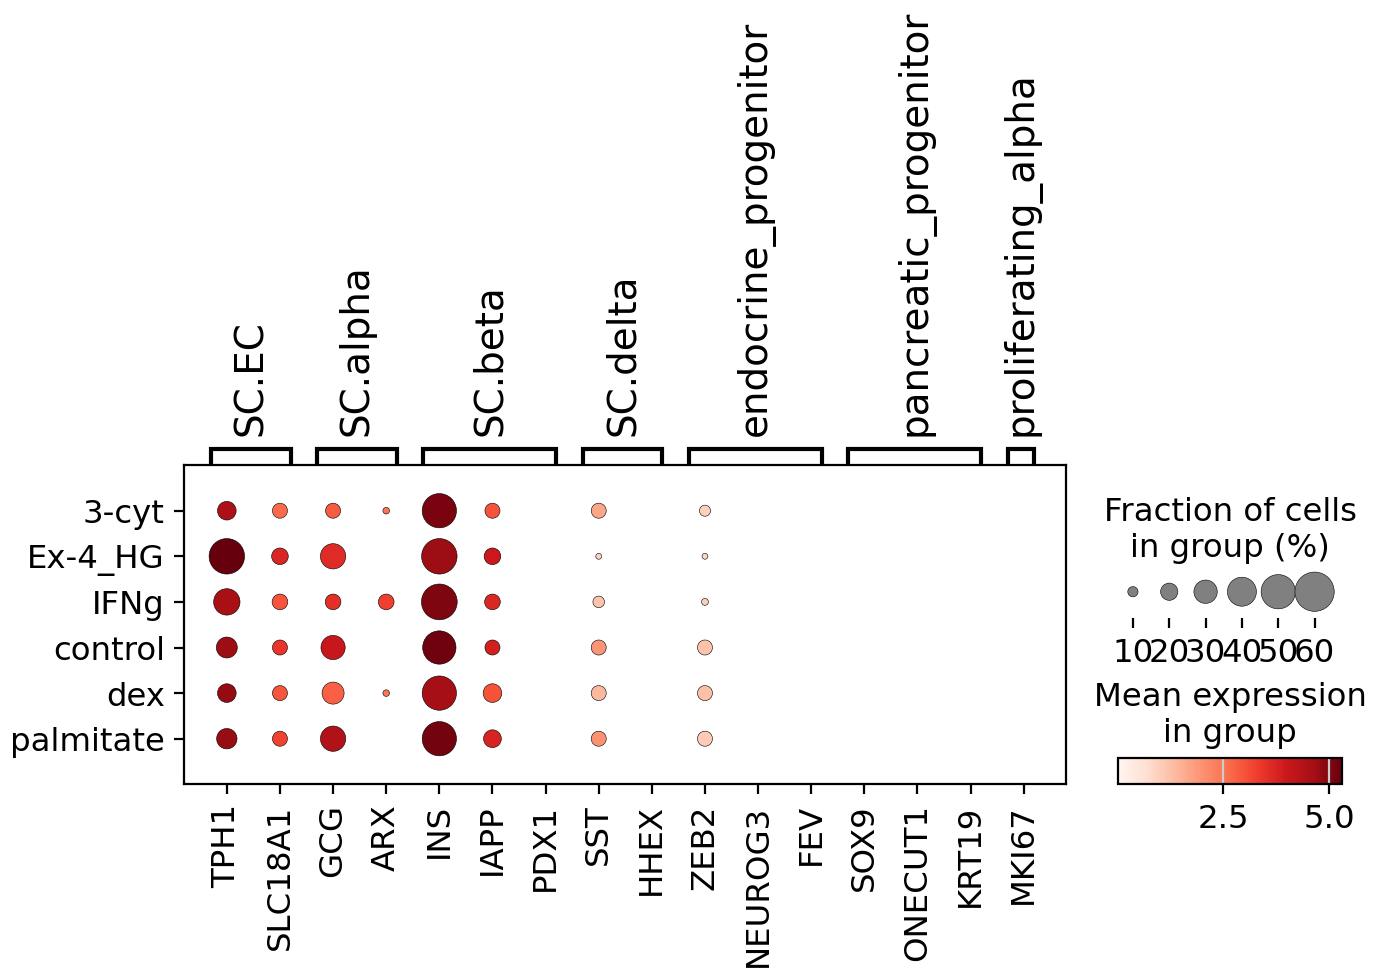

In [227]:
sc.pl.dotplot(
    pp_pdata,
    groupby="condition",
    var_names=marker_genes_in_data,
    #standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    layer="log_cpm",
    expression_cutoff=5
)

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


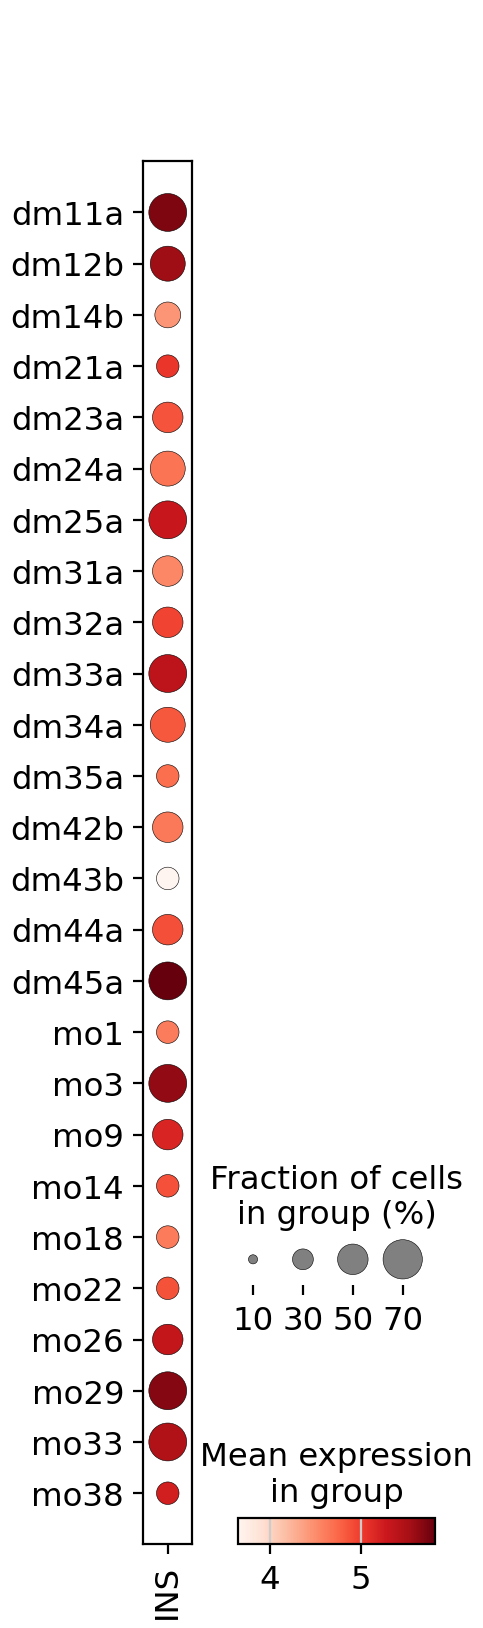

In [228]:
sc.pl.dotplot(
    pp_pdata,
    groupby="sample",
    var_names="INS",
    #standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    layer="log_cpm",
    expression_cutoff=5
)

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


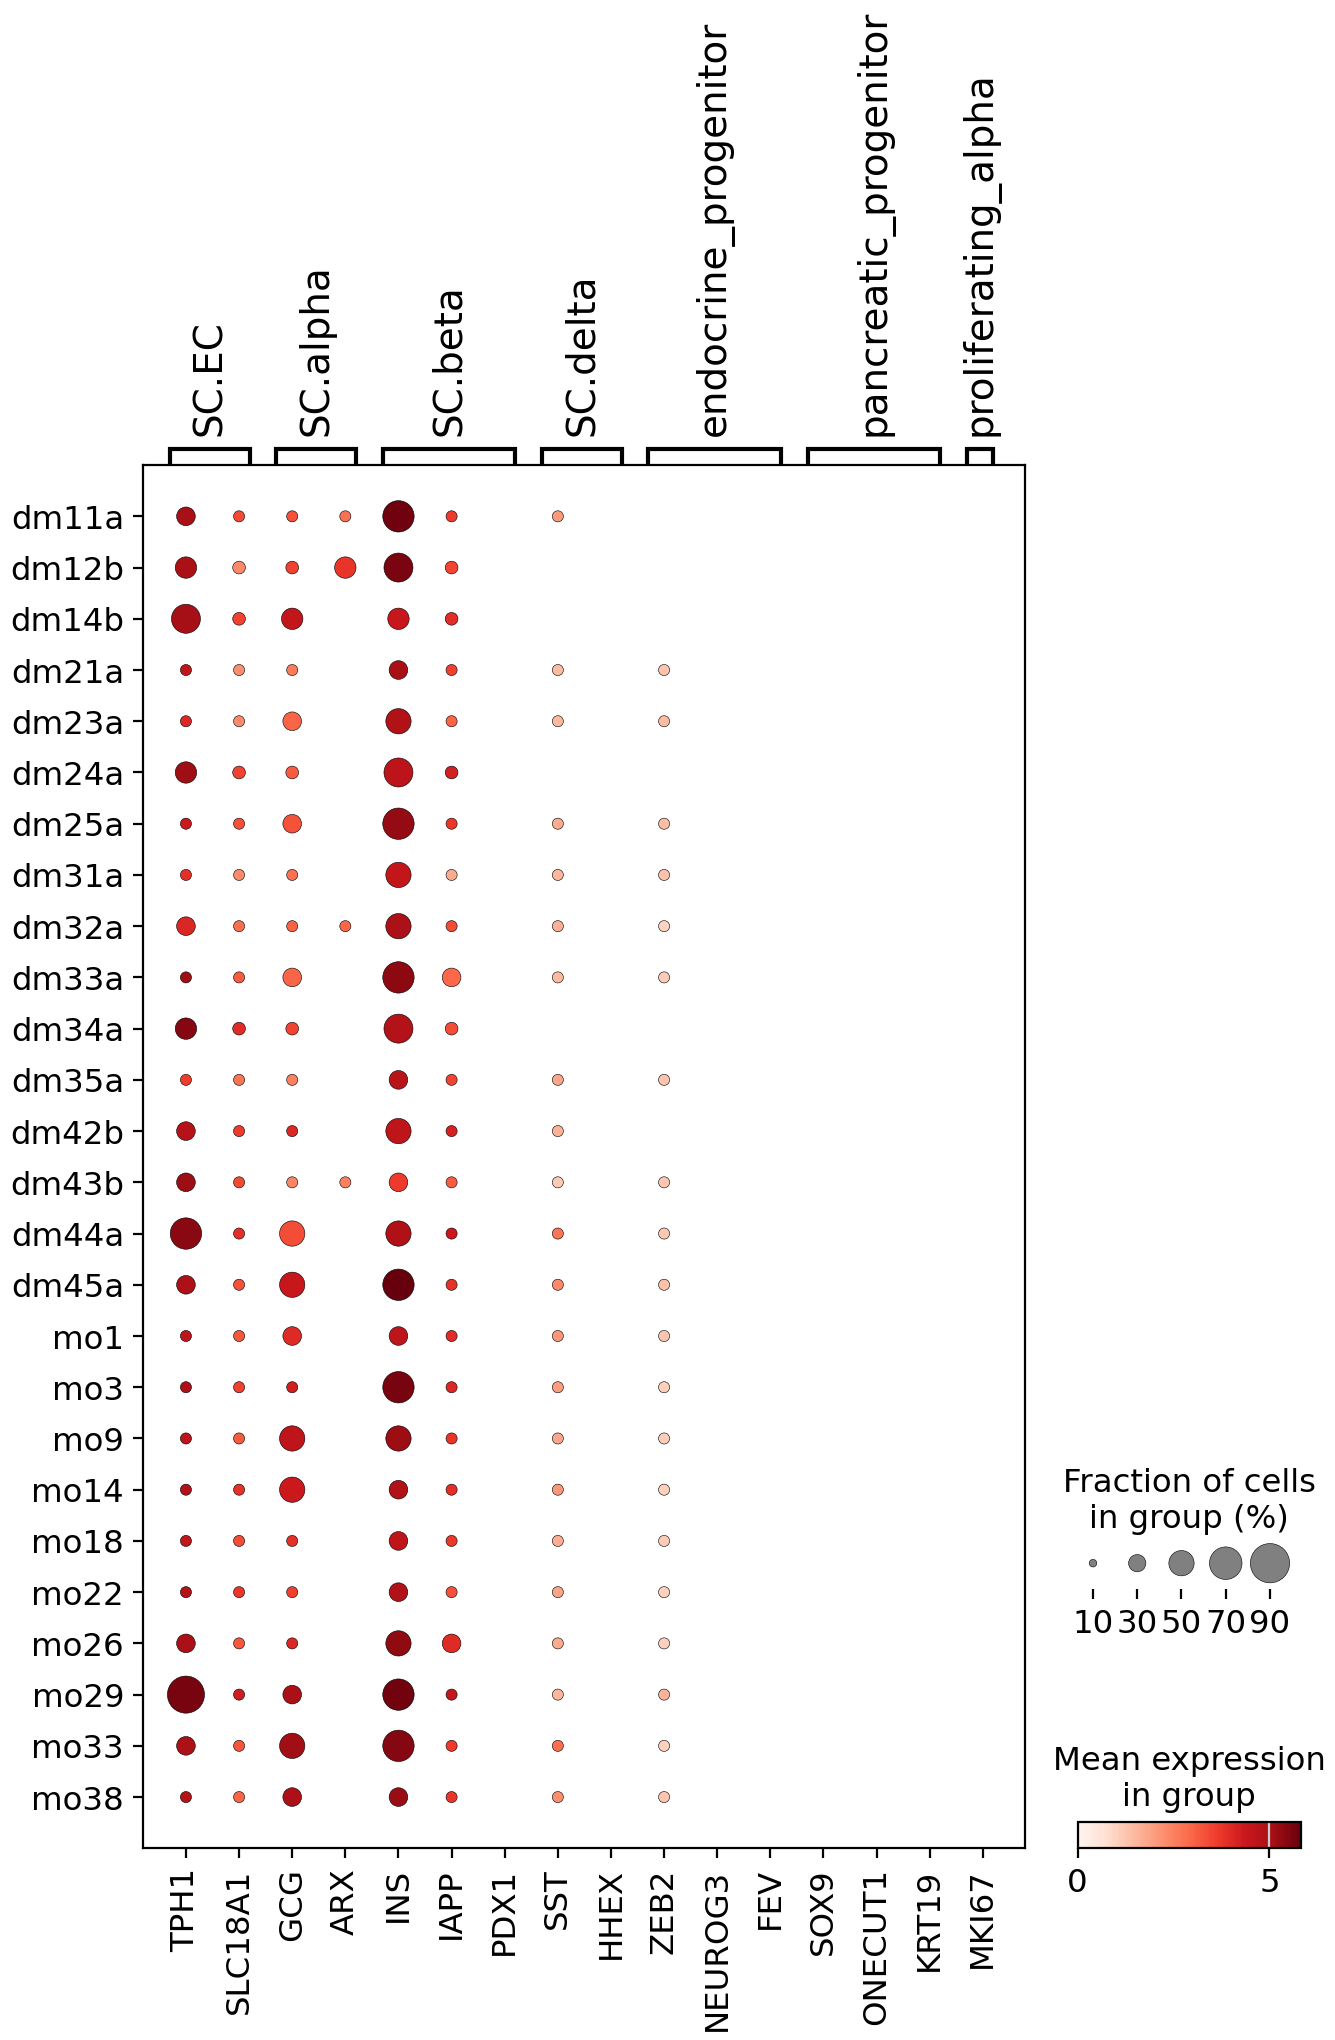

In [229]:
sc.pl.dotplot(
    pp_pdata,
    groupby="sample",
    var_names=marker_genes_in_data,
    #standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    layer="log_cpm",
    expression_cutoff=5
)

    using 'X_pca' with n_pcs = 10
Storing dendrogram info using `.uns['dendrogram_sample']`
categories: dm11a, dm12b, dm14b, etc.
var_group_labels: SC.EC, SC.alpha, SC.beta, etc.


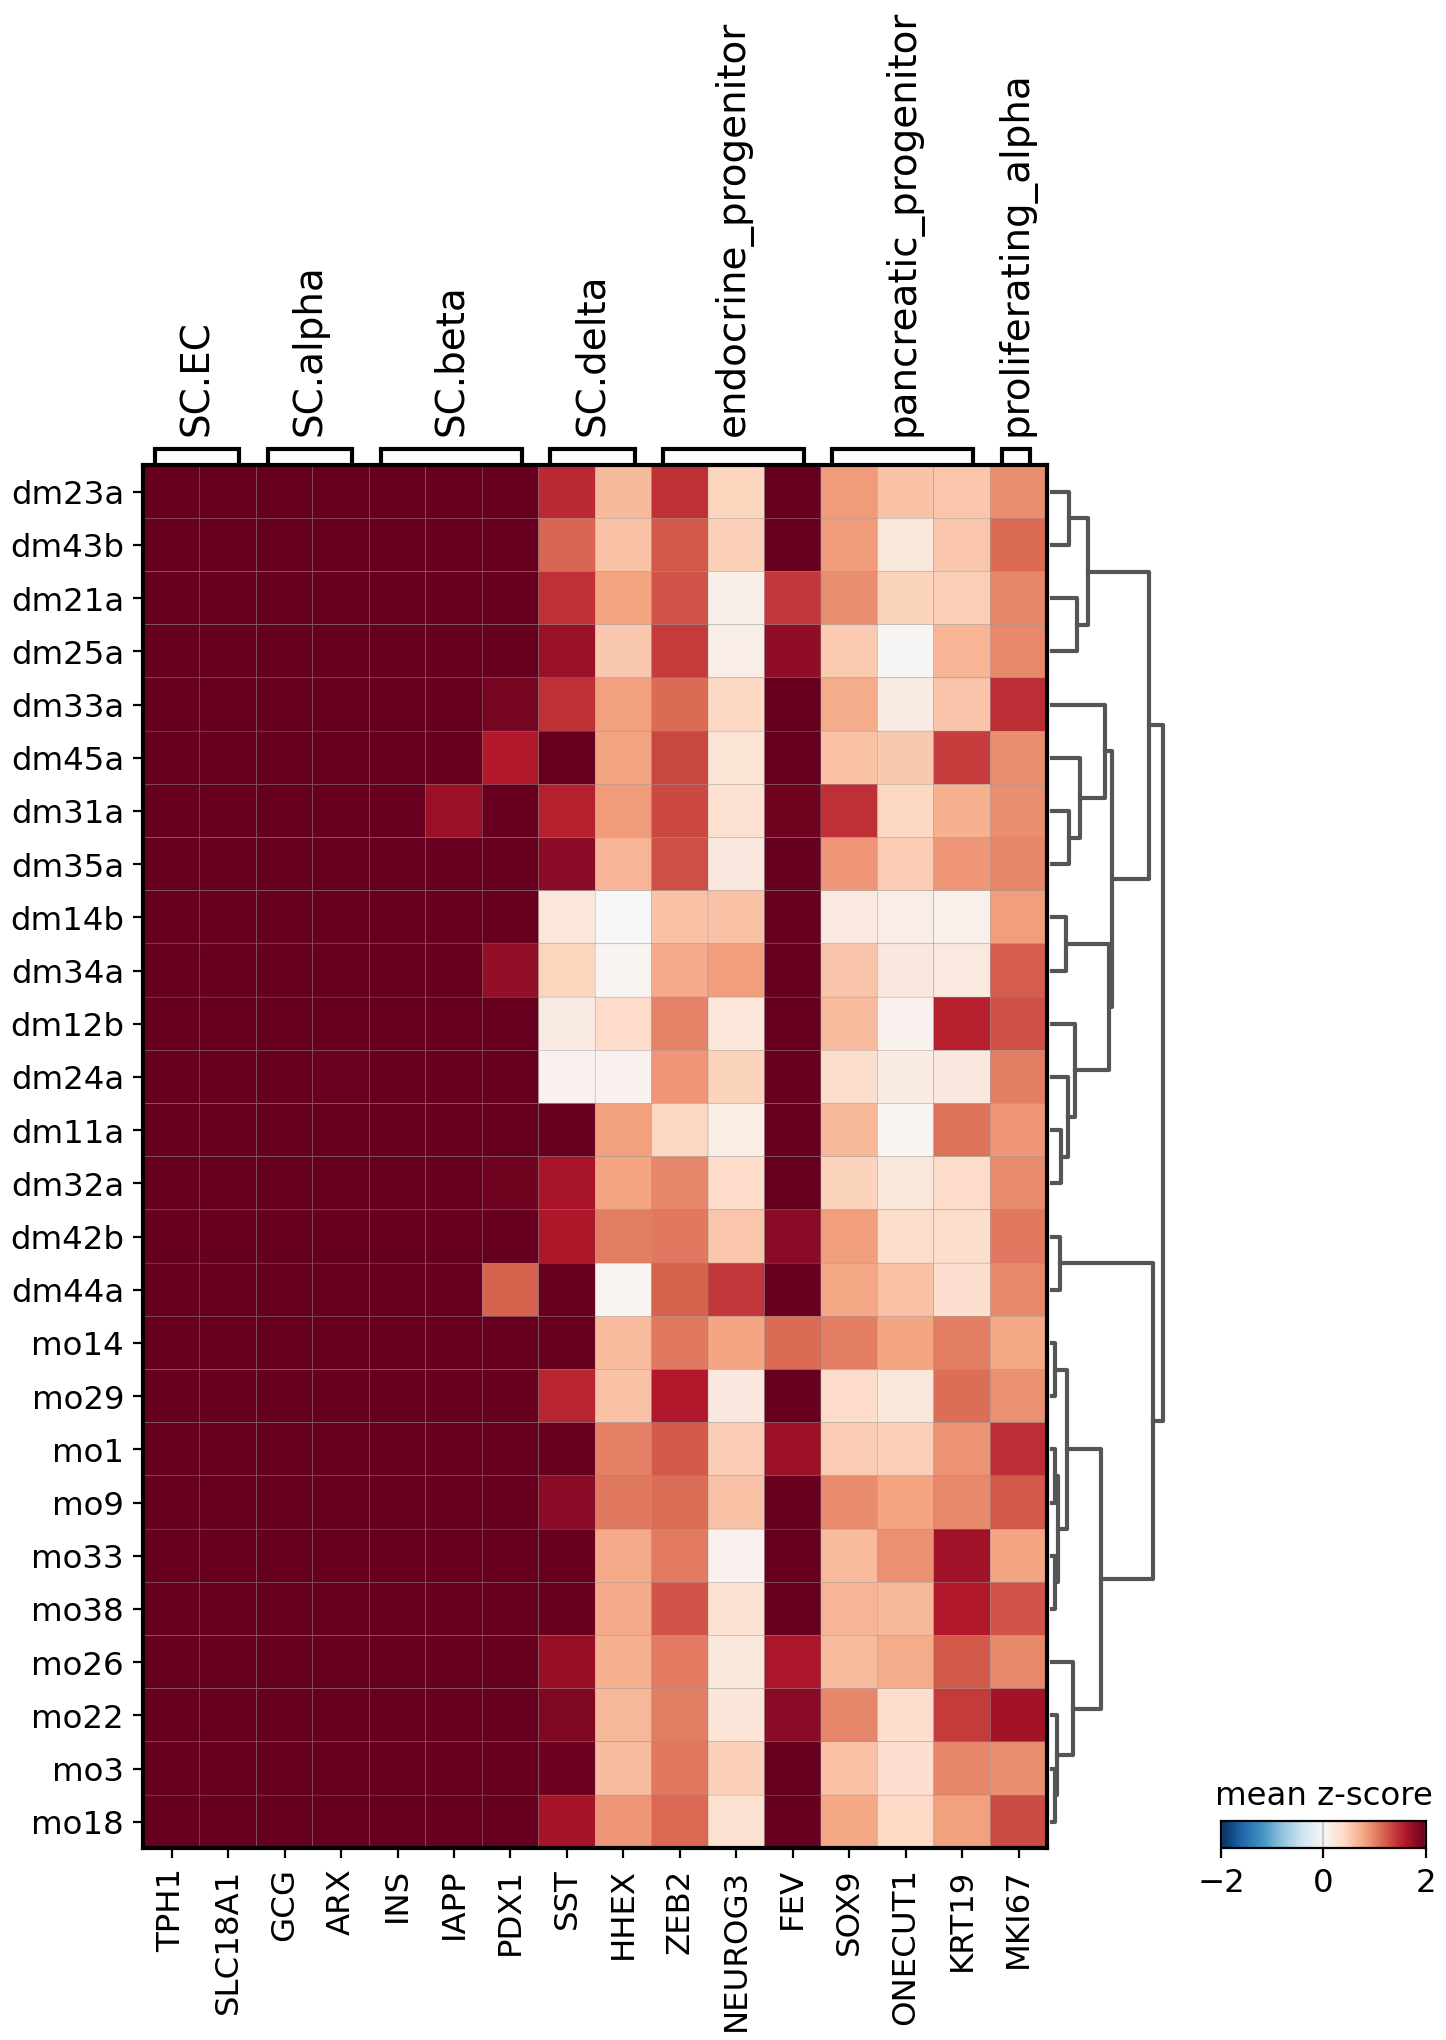

In [230]:
sc.pl.matrixplot(pp_pdata, marker_genes_dict, 'sample', dendrogram=True, layer='log_cpm',
                 colorbar_title='mean z-score', vmin=-2, vmax=2, cmap='RdBu_r')

In [234]:
pp_beta_pdata = pp_pdata[pp_pdata.obs["integrated_manual_cellid_annotation"] == "SC_beta"].copy()
pp_beta_pdata

AnnData object with n_obs × n_vars = 26 × 32637
    obs: 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'outlier', 'mt_outlier', 'scrublet_predicted_doublet', 'scDblFinder_doublet_class', 'scDblFinder_predicted_doublet', 'cellranger_predicted_doublet', 'doublet_filter', 'sample', 'integrated_manual_cellid_annotation', 'batch', 'timepoint', 'condition', 'pseudobulk', 'psbulk_n_cells', 'psbulk_counts'
    var: 'sctransform_genes', 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca', 'sample_colors', 'integrated_manual_cellid_annotation_colors', 'condition_colors', 'pca_anova', 'dendrogram_sample'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'log_cpm'

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


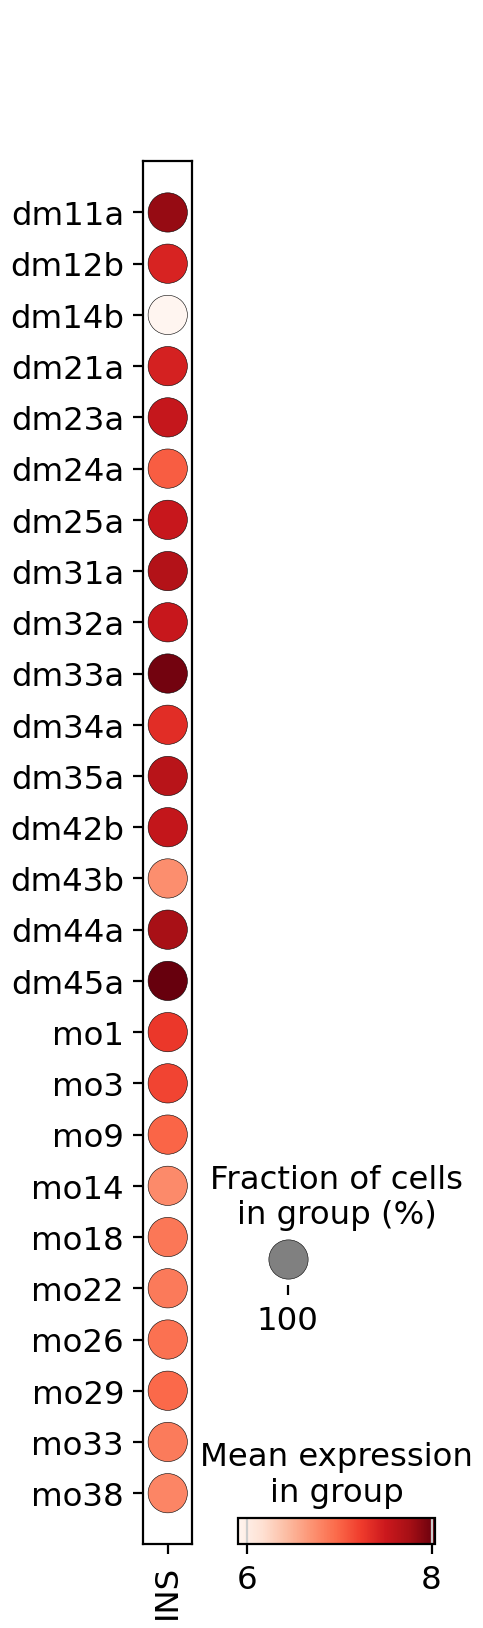

In [236]:
sc.pl.dotplot(
    pp_beta_pdata,
    groupby="sample",
    var_names="INS",
    #standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    layer="log_cpm",
    dot_min=0.99,
    dot_max=1,
)

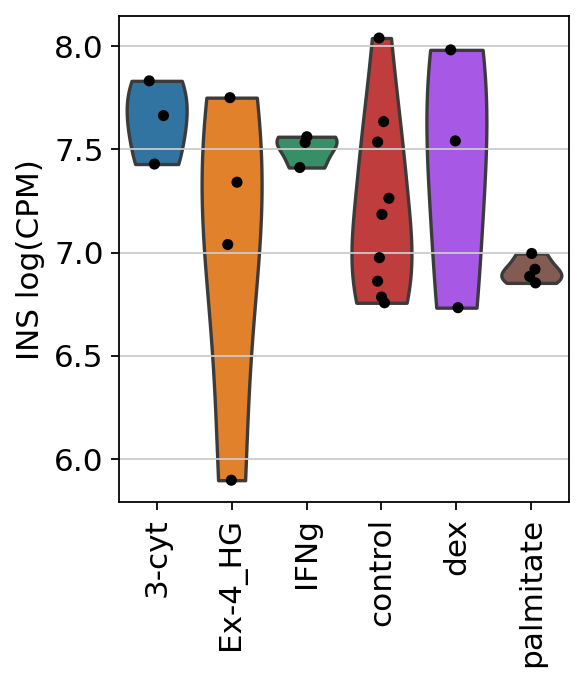

In [ ]:
sc.pl.violin(
    pp_beta_pdata,
    "INS",
    layer="log_cpm",
    groupby="condition",
    rotation=90,
    stripplot=True,
    jitter=True,
    size=5,
    ylabel="INS log(CPM)",
)

# Old pb code

In [ ]:
# If cells_per_pb is not None, create a new column in adata.obs for a pseudobulk assignment
### Cells should be grouped by the groupby_col and then randomly assigned to pseudobulks of size cells_per_pb, the last pseudobulk may be smaller
### This should respect the compare_col, so that cells from the same condition are not assigned to the same pseudobulk
### If cells_per_pb is None, then the pseudobulk column should be the same as the groupby_col

random.seed(1234)
if cells_per_pb:

    # Create a new column in adata.obs for pseudobulk assignment
    adata.obs["pseudobulk"] = np.nan
    
    # Loop through each unique compare_col value
    for compare_val in adata.obs[compare_col].unique():
        
        # Loop through each unique groupby_col value
        for groupby_val in adata.obs[groupby_col].unique():

            # Grab cell indices for this groupby_val and compare_val
            cell_indices = adata.obs[(adata.obs[groupby_col] == groupby_val) & (adata.obs[compare_col] == compare_val)].index.values

            # Shuffle the cell indices
            random.shuffle(cell_indices)

            # Assign cells to pseudobulks
            for i, start in enumerate(range(0, len(cell_indices), cells_per_pb)):
                adata.obs.loc[cell_indices[start:start+cells_per_pb], "pseudobulk"] = f"{compare_val}_{groupby_val}_{i}"
else:
    adata.obs["pseudobulk"] = adata.obs[groupby_col]
        
# Check that every cell has a pseudobulk assignment
if adata.obs.pseudobulk.isna().sum() == 0:
    print("All cells have a pseudobulk assignment.")